# **Mounting**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

os.chdir('/content/drive/MyDrive/Colab Notebooks')
%pwd

'/content/drive/MyDrive/Colab Notebooks'

Import packages and load data


In [ ]:
# import packages
import numpy as np
import matplotlib.pyplot as plt
#from reg_utils import sigmoid, relu, plot_decision_boundary, initialize_parameters, load_2D_dataset, predict_dec
#from reg_utils import compute_cost, predict, forward_propagation, backward_propagation, update_parameters
import scipy.io

import torch
import torch.utils.data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

#%matplotlib inline
#plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
#plt.rcParams['image.interpolation'] = 'nearest'
#plt.rcParams['image.cmap'] = 'gray'

Define Training and Test dataset

In [ ]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class SpiralTrainDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        self.inp = df.iloc[:1000, :2].values
        self.outp = np.expand_dims( df.iloc[:1000,-1].values, axis=1 )
        self.inp = self.normalize(self.inp)

    def __len__(self):
        return self.inp.shape[0]

    def __getitem__(self,idx):
        inp = torch.FloatTensor(self.inp[idx])
        outp = torch.FloatTensor(self.outp[idx])
        return inp, outp

    def normalize(self, d_array ):
        m = np.mean( d_array, axis=0 )
        s = np.std( d_array, axis=0 )
        return (d_array - m) / s


class SpiralTestDataset(Dataset):
    def __init__(self, csv_path):
        df = pd.read_csv(csv_path)
        self.inp = df.iloc[1000:, :2].values
        self.outp = np.expand_dims( df.iloc[1000:,-1].values, axis=1 )
        self.inp = self.normalize(self.inp)

    def __len__(self):
        return self.inp.shape[0]

    def __getitem__(self,idx):
        inp = torch.FloatTensor(self.inp[idx])
        outp = torch.FloatTensor(self.outp[idx])
        return inp, outp

    def normalize(self, d_array ):
        m = np.mean( d_array, axis=0 )
        s = np.std( d_array, axis=0 )
        return (d_array - m) / s

Create data loaders for training and test datasets

In [ ]:
train_data = SpiralTrainDataset("result.csv")
test_data  = SpiralTestDataset("result.csv")

train_batch_size = 256  # you can adjust this hyperparameter
test_batch_size = 1000

train_loader = torch.utils.data.DataLoader( dataset = train_data,
                                           batch_size=train_batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader( dataset = test_data,
                                           batch_size=test_batch_size,
                                           shuffle=True)

In [ ]:
print(f"train_data size : {len(train_loader.dataset)}")
print(f"test_data size : {len(test_loader.dataset)}")

train_data size : 1000
test_data size : 600


Visualize data

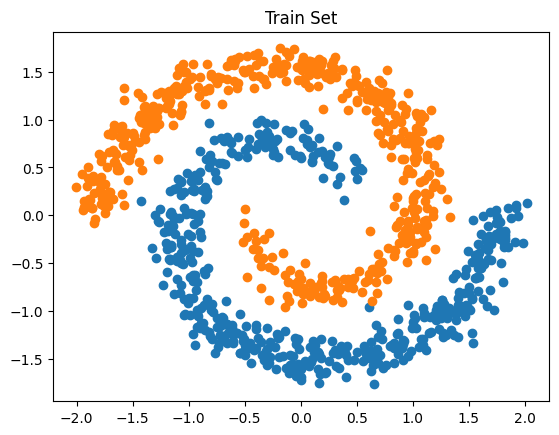

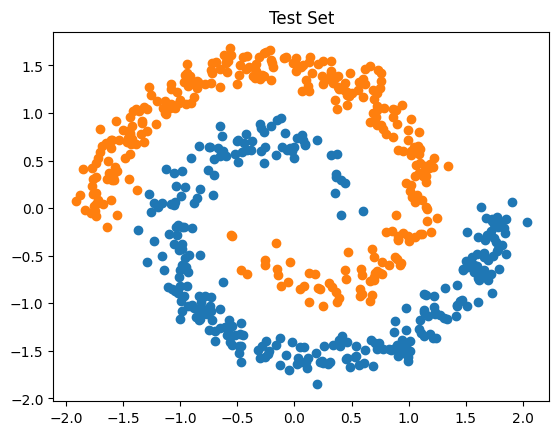

In [ ]:
cls1_mask = (train_loader.dataset.outp[:,0] == 0)
cls2_mask = (train_loader.dataset.outp[:,0] == 1)

cls1 = train_loader.dataset.inp[cls1_mask,:]
cls2 = train_loader.dataset.inp[cls2_mask,:]

plt.scatter(cls1[:,0], cls1[:,1])
plt.scatter(cls2[:,0], cls2[:,1])
plt.title('Train Set')
plt.show()

cls1_mask2 = (test_loader.dataset.outp[:,0] == 0)
cls2_mask2 = (test_loader.dataset.outp[:,0] == 1)

cls12 = test_loader.dataset.inp[cls1_mask2,:]
cls22 = test_loader.dataset.inp[cls2_mask2,:]

plt.scatter(cls12[:,0], cls12[:,1])
plt.scatter(cls22[:,0], cls22[:,1])
plt.title('Test Set')
plt.show()

**Problem Statement**: You are given the following 2D dataset.

**Your goal**: Use a deep learning model to classify blue (1) and red (0).

**Homework** : Design and run your model.
- Use 2 hidden layers at most.
- Show learning curves with both training and test datasets.
- Tune your model to show around 95% accuracy with the given test dataset.
- Write and submit an one-pape report with your code

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
class NNModel(torch.nn.Module):
    def __init__(self, layer_dim, dropout_p ):
        super(NNModel,self).__init__()

        self.l1 = nn.Linear(layer_dim[0],layer_dim[1])
        self.l2 = nn.Linear(layer_dim[1],layer_dim[2])

        torch.nn.init.xavier_uniform_(self.l1.weight)
        torch.nn.init.xavier_uniform_(self.l2.weight)

        self.drop_layer = nn.Dropout(p=dropout_p)

    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.drop_layer(x)
        return torch.sigmoid(self.l2(x))

In [ ]:
# 분류 결과 그리기
def plot_decision_boundary(nnmodel, train_loader, test_loader):
    # Plot decision boundary for train set
    nnmodel.eval()
    train_x = train_loader.dataset.inp
    train_y = train_loader.dataset.outp
    train_x = torch.Tensor(train_x).to(device)
    train_y = torch.Tensor(train_y).to(device)
    train_output = nnmodel(train_x)
    train_predictions = (train_output > 0.5).cpu().detach().numpy()

    # Plot decision boundary for test set
    nnmodel.eval()
    test_x = test_loader.dataset.inp
    test_y = test_loader.dataset.outp
    test_x = torch.Tensor(test_x).to(device)
    test_y = torch.Tensor(test_y).to(device)
    test_output = nnmodel(test_x)
    test_predictions = (test_output > 0.5).cpu().detach().numpy()

     # Plot decision boundaries
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.title('Train Set')
    plt.scatter(train_x[:, 0].cpu().numpy(), train_x[:, 1].cpu().numpy(), c=train_y[:, 0].cpu().numpy(), cmap='bwr', vmin=0, vmax=1)
    plt.scatter(train_x[:, 0].cpu().numpy(), train_x[:, 1].cpu().numpy(), c=train_predictions[:, 0], marker='x', cmap='bwr', vmin=0, vmax=1)
    plt.subplot(1, 2, 2)
    plt.title('Test Set')
    plt.scatter(test_x[:, 0].cpu().numpy(), test_x[:, 1].cpu().numpy(), c=test_y[:, 0].cpu().numpy(), cmap='bwr', vmin=0, vmax=1)
    plt.scatter(test_x[:, 0].cpu().numpy(), test_x[:, 1].cpu().numpy(), c=test_predictions[:, 0], marker='x', cmap='bwr', vmin=0, vmax=1)
    plt.show()


In [ ]:
def model( learning_rate = 0.3, num_iterations = 10000, print_cost = True, lambd = 0., keep_prob = 1.):

    costs = []                            # to keep track of the cost
    test_costs = []
    train_acc = 0
    test_acc = 0

    x_dim = 2
    layers_dims = [2, 10, 1]

    nnmodel = NNModel(layers_dims, 1.0-keep_prob)
    optimizer = optim.Adam(nnmodel.parameters(), lr=learning_rate, weight_decay=lambd )

    nnmodel = nnmodel.to(device)

    def train(epoch):
        nnmodel.train()
        for batch_idx, (train_x, train_y) in enumerate(train_loader):
            (test_x, test_y) = next(iter(test_loader))

            train_x = train_x.to(device)
            train_y = train_y.to(device)
            test_x = test_x.to(device)
            test_y = test_y.to(device)

            output = nnmodel(train_x)
            test_output = nnmodel(test_x)

            optimizer.zero_grad()
            loss = F.binary_cross_entropy(output, train_y)
            with torch.no_grad():
                test_loss = F.binary_cross_entropy(test_output, test_y)

            loss.backward()
            optimizer.step()
            if epoch%100==1 and batch_idx==0:
                print("Cost after epoch {} batch_idx {}, Loss : {}".format(epoch, batch_idx, loss))
                costs.append(loss.item())
                test_costs.append(test_loss.item())

    def test():
        test_loss=0
        correct=0
        nnmodel.eval()

        for data,target in train_loader:
            data = data.to(device)
            target = target.to(device)

            output = nnmodel(data)
            test_loss += F.binary_cross_entropy(output, target)
#            test_loss += F.binary_cross_entropy(output, target.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor))
            pred = (output>0.5)

            temp = pred.eq(target.view_as(pred))
            correct += temp.sum()
        test_loss /= len(train_loader.dataset)
        train_acc = 100. * correct / len(train_loader.dataset)
        print('*** Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                test_loss, correct, len(train_loader.dataset),
                train_acc))

        test_loss=0
        correct=0
        for data,target in test_loader:
            data = data.to(device)
            target = target.to(device)

            output = nnmodel(data)
            test_loss += F.binary_cross_entropy(output, target )
#            test_loss += F.binary_cross_entropy(output, target.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor))
            pred = (output>0.5)
            temp = pred.eq(target.view_as(pred))
            correct += temp.sum()
        test_loss /= len(test_loader.dataset)
        test_acc = 100. * correct / len(test_loader.dataset)
        print('*** Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                test_loss, correct, len(test_loader.dataset),
                test_acc))
        return train_acc, test_acc

    for epoch in range(1,num_iterations):
       train(epoch)
    train_acc, test_acc = test()

    # plot the cost
    plt.plot(costs)
    plt.plot(test_costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    # Plot decision boundary
    plot_decision_boundary(nnmodel, train_loader, test_loader)

    return train_acc, test_acc

# **1. learning rate의 변화에 따른 정확도 확인 num_iterations : 1000, node : 10, lambd : 0.**

   learning rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]

[Learning rate의 변화에 따른 정확도 확인] - (num_iterations : 1000, lambd : 0.)
[ Learning rate : 0.001 ]
Cost after epoch 1 batch_idx 0, Loss : 0.7633770108222961
Cost after epoch 101 batch_idx 0, Loss : 0.513892650604248
Cost after epoch 201 batch_idx 0, Loss : 0.4529147148132324
Cost after epoch 301 batch_idx 0, Loss : 0.4087209105491638
Cost after epoch 401 batch_idx 0, Loss : 0.4066722095012665
Cost after epoch 501 batch_idx 0, Loss : 0.37790536880493164
Cost after epoch 601 batch_idx 0, Loss : 0.31438684463500977
Cost after epoch 701 batch_idx 0, Loss : 0.4150712490081787
Cost after epoch 801 batch_idx 0, Loss : 0.38050276041030884
Cost after epoch 901 batch_idx 0, Loss : 0.364963173866272
*** Train set: Average loss: 0.0014, Accuracy: 846/1000 (85%)
*** Test set: Average loss: 0.0006, Accuracy: 501/600 (84%)


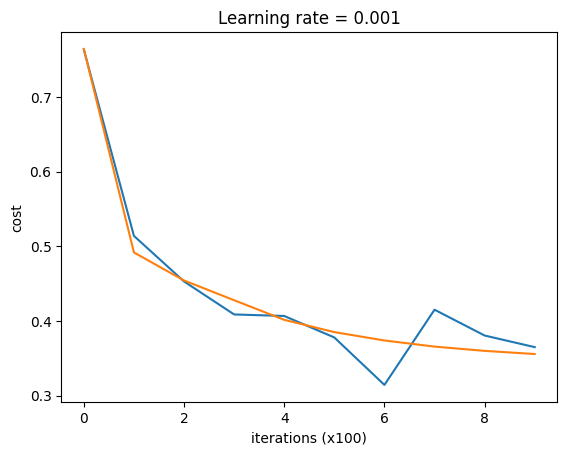

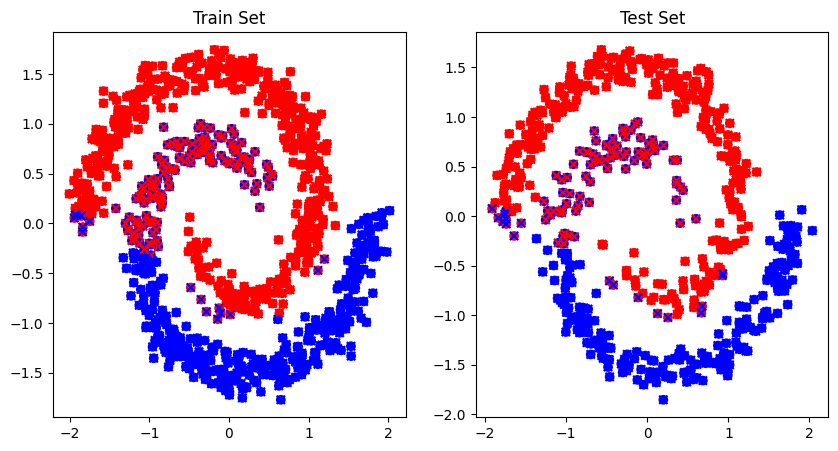

[ Learning rate : 0.005 ]
Cost after epoch 1 batch_idx 0, Loss : 0.7699735164642334
Cost after epoch 101 batch_idx 0, Loss : 0.2644833028316498
Cost after epoch 201 batch_idx 0, Loss : 0.14682935178279877
Cost after epoch 301 batch_idx 0, Loss : 0.08605484664440155
Cost after epoch 401 batch_idx 0, Loss : 0.07290925085544586
Cost after epoch 501 batch_idx 0, Loss : 0.0475848913192749
Cost after epoch 601 batch_idx 0, Loss : 0.028653696179389954
Cost after epoch 701 batch_idx 0, Loss : 0.029184836894273758
Cost after epoch 801 batch_idx 0, Loss : 0.034015439450740814
Cost after epoch 901 batch_idx 0, Loss : 0.014625738374888897
*** Train set: Average loss: 0.0001, Accuracy: 994/1000 (99%)
*** Test set: Average loss: 0.0001, Accuracy: 590/600 (98%)


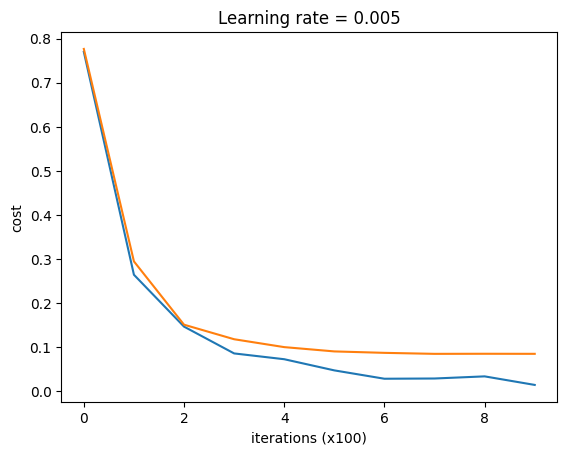

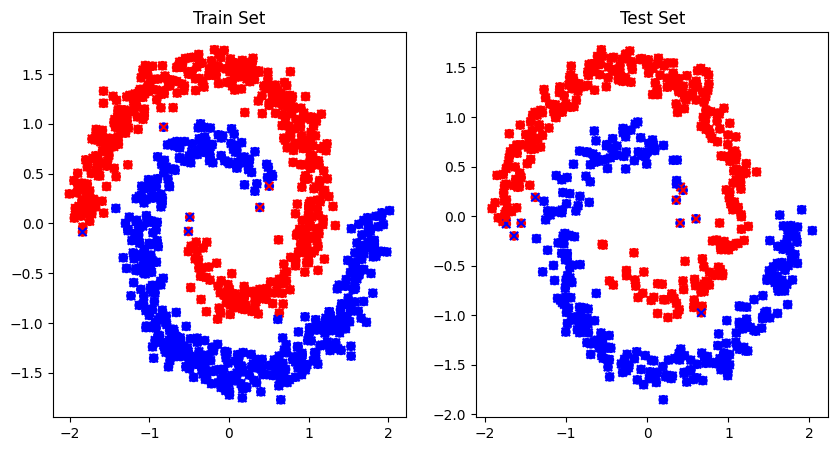

[ Learning rate : 0.01 ]
Cost after epoch 1 batch_idx 0, Loss : 0.6664059162139893
Cost after epoch 101 batch_idx 0, Loss : 0.13137854635715485
Cost after epoch 201 batch_idx 0, Loss : 0.0772487223148346
Cost after epoch 301 batch_idx 0, Loss : 0.025271782651543617
Cost after epoch 401 batch_idx 0, Loss : 0.017970075830817223
Cost after epoch 501 batch_idx 0, Loss : 0.03039313107728958
Cost after epoch 601 batch_idx 0, Loss : 0.022317208349704742
Cost after epoch 701 batch_idx 0, Loss : 0.029693273827433586
Cost after epoch 801 batch_idx 0, Loss : 0.007639317773282528
Cost after epoch 901 batch_idx 0, Loss : 0.009368929080665112
*** Train set: Average loss: 0.0001, Accuracy: 997/1000 (100%)
*** Test set: Average loss: 0.0001, Accuracy: 591/600 (98%)


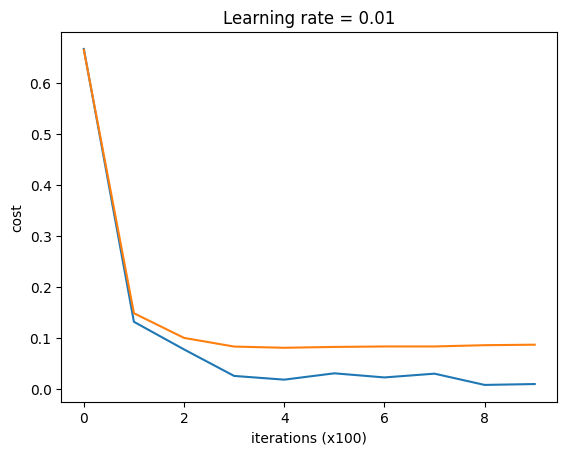

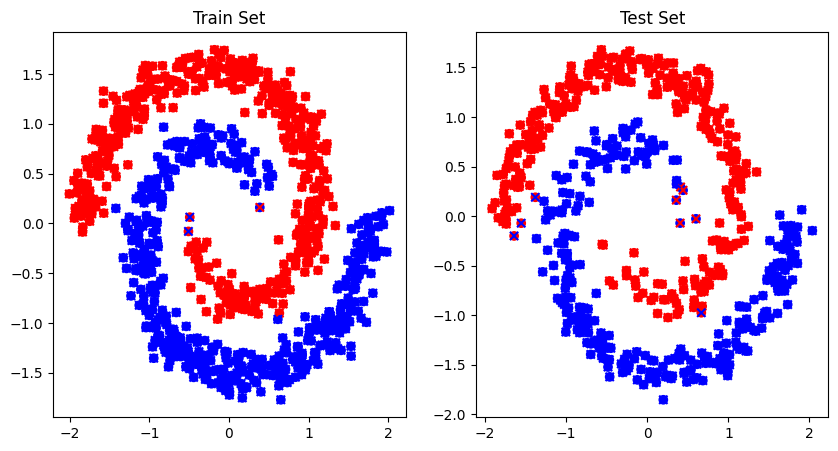

[ Learning rate : 0.05 ]
Cost after epoch 1 batch_idx 0, Loss : 0.6151398420333862
Cost after epoch 101 batch_idx 0, Loss : 0.03796334192156792
Cost after epoch 201 batch_idx 0, Loss : 0.010691005736589432
Cost after epoch 301 batch_idx 0, Loss : 0.012908762320876122
Cost after epoch 401 batch_idx 0, Loss : 0.016005340963602066
Cost after epoch 501 batch_idx 0, Loss : 0.005426722578704357
Cost after epoch 601 batch_idx 0, Loss : 0.007275247480720282
Cost after epoch 701 batch_idx 0, Loss : 0.008177733980119228
Cost after epoch 801 batch_idx 0, Loss : 0.024939140304923058
Cost after epoch 901 batch_idx 0, Loss : 0.0059453630819916725
*** Train set: Average loss: 0.0001, Accuracy: 998/1000 (100%)
*** Test set: Average loss: 0.0002, Accuracy: 591/600 (98%)


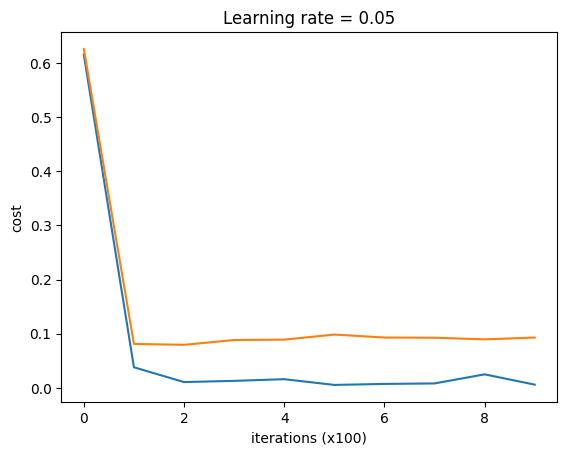

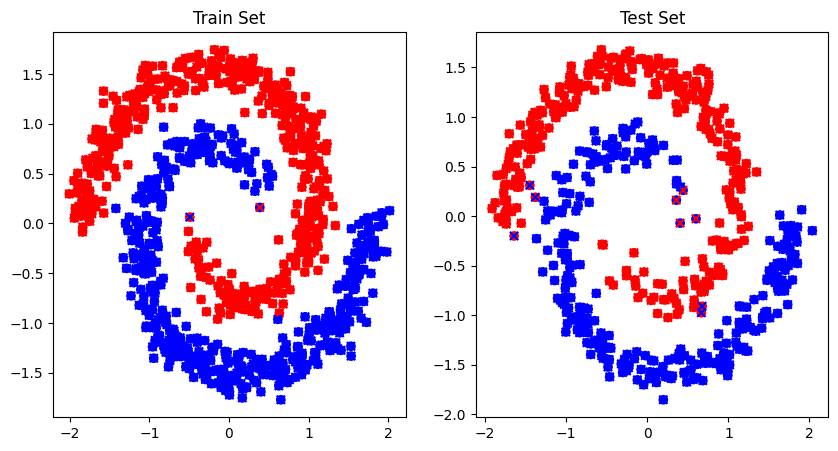

[ Learning rate : 0.1 ]
Cost after epoch 1 batch_idx 0, Loss : 0.785396933555603
Cost after epoch 101 batch_idx 0, Loss : 0.002503004390746355
Cost after epoch 201 batch_idx 0, Loss : 0.00450254138559103
Cost after epoch 301 batch_idx 0, Loss : 0.0028779967688024044
Cost after epoch 401 batch_idx 0, Loss : 0.007153271231800318
Cost after epoch 501 batch_idx 0, Loss : 0.00047775357961654663
Cost after epoch 601 batch_idx 0, Loss : 0.0010441088816151023
Cost after epoch 701 batch_idx 0, Loss : 0.0011436862405389547
Cost after epoch 801 batch_idx 0, Loss : 0.07345709949731827
Cost after epoch 901 batch_idx 0, Loss : 0.006165646016597748
*** Train set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)
*** Test set: Average loss: 0.0007, Accuracy: 594/600 (99%)


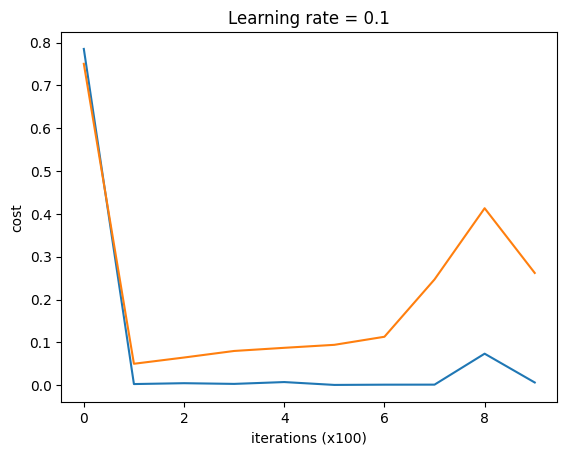

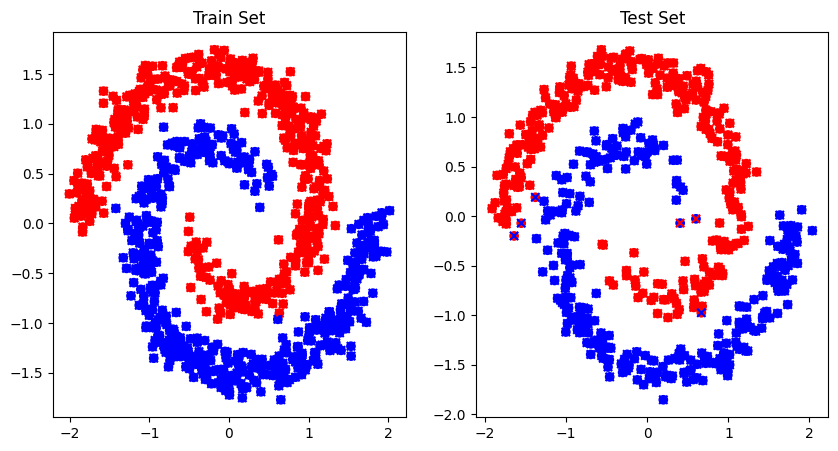

[ Learning rate : 0.3 ]
Cost after epoch 1 batch_idx 0, Loss : 0.5996145009994507
Cost after epoch 101 batch_idx 0, Loss : 0.22131691873073578
Cost after epoch 201 batch_idx 0, Loss : 0.0024022923316806555
Cost after epoch 301 batch_idx 0, Loss : 0.0014458093792200089
Cost after epoch 401 batch_idx 0, Loss : 0.0008957786485552788
Cost after epoch 501 batch_idx 0, Loss : 0.022051654756069183
Cost after epoch 601 batch_idx 0, Loss : 0.011115426197648048
Cost after epoch 701 batch_idx 0, Loss : 0.0005491337506100535
Cost after epoch 801 batch_idx 0, Loss : 0.002071718219667673
Cost after epoch 901 batch_idx 0, Loss : 0.0032513090409338474
*** Train set: Average loss: 0.0000, Accuracy: 1000/1000 (100%)
*** Test set: Average loss: 0.0002, Accuracy: 593/600 (99%)


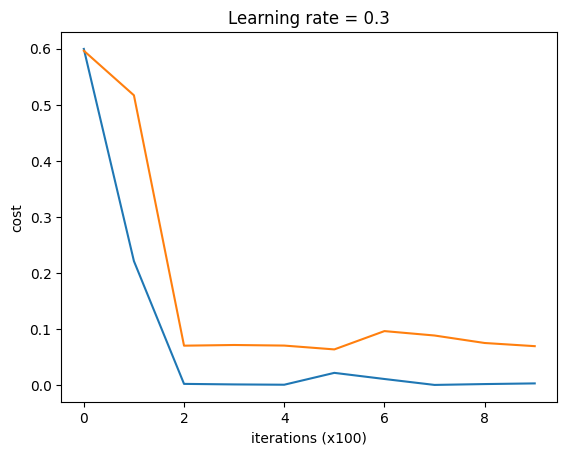

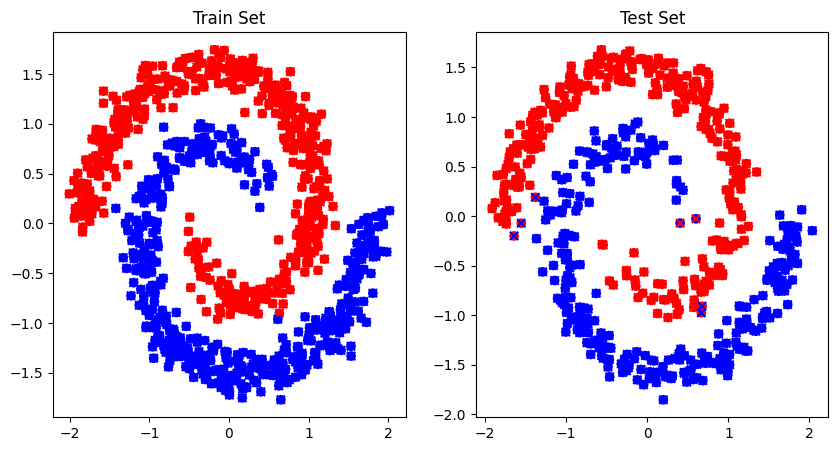

[ Learning rate : 0.5 ]
Cost after epoch 1 batch_idx 0, Loss : 0.8925806283950806
Cost after epoch 101 batch_idx 0, Loss : 0.028849270194768906
Cost after epoch 201 batch_idx 0, Loss : 0.00604048278182745
Cost after epoch 301 batch_idx 0, Loss : 0.011660397052764893
Cost after epoch 401 batch_idx 0, Loss : 0.0023921700194478035
Cost after epoch 501 batch_idx 0, Loss : 0.09650656580924988
Cost after epoch 601 batch_idx 0, Loss : 0.0037171870935708284
Cost after epoch 701 batch_idx 0, Loss : 0.4007474184036255
Cost after epoch 801 batch_idx 0, Loss : 0.007244317792356014
Cost after epoch 901 batch_idx 0, Loss : 0.031068140640854836
*** Train set: Average loss: 0.0005, Accuracy: 994/1000 (99%)
*** Test set: Average loss: 0.0001, Accuracy: 594/600 (99%)


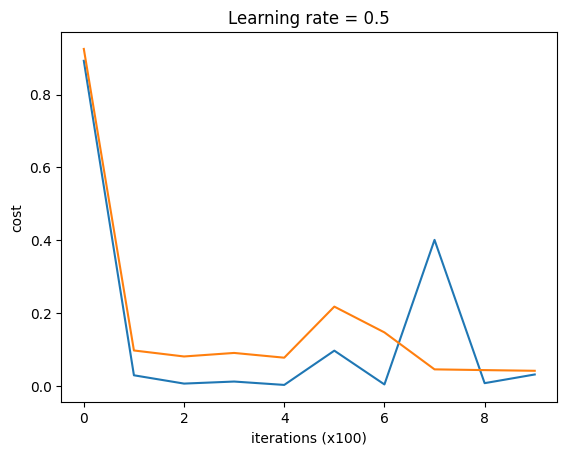

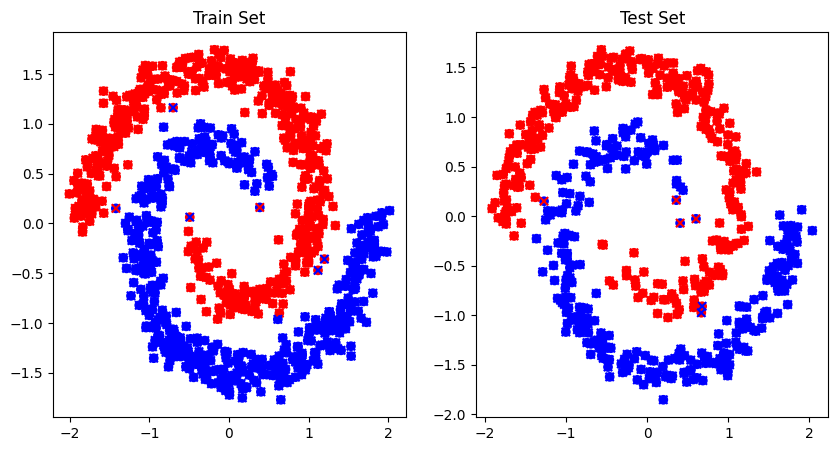

In [ ]:
# learning rate의 변화에 따른 정확도 확인 num_iterations : 1000, lambd : 0.
rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]

train_list = []
test_list = []

print("[Learning rate의 변화에 따른 정확도 확인] - (num_iterations : 1000, lambd : 0.)")
for i in rate:
  print("[ Learning rate :", i,"]")
  train_acc, test_acc = model(learning_rate=i, num_iterations=1000, lambd=0.)
  train_acc_value = train_acc.item()  # 실제 값 추출
  test_acc_value = test_acc.item()  # 실제 값 추출
  train_list.append(train_acc_value)
  test_list.append(test_acc_value)

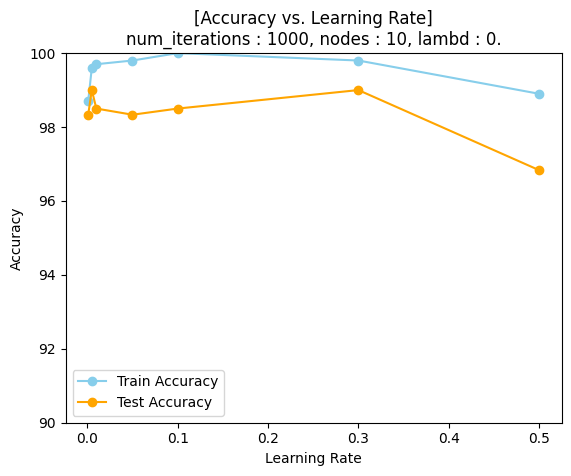

In [ ]:
# Train, test 정확도 확인 plot - num_iterations : 1000, lambd : 0.
import matplotlib.pyplot as plt

learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]

fig1, ax1 = plt.subplots()
ax1.plot(learning_rates, train_list, color='skyblue', marker='o', label='Train Accuracy')
ax1.plot(learning_rates, test_list, color='orange', marker='o', label='Test Accuracy')
ax1.set_xlabel('Learning Rate')
ax1.set_ylabel('Accuracy')
ax1.set_title('[Accuracy vs. Learning Rate]\nnum_iterations : 1000, nodes : 10, lambd : 0.')
ax1.set_ylim(90, 100)
ax1.legend()

# 변수에 그림 저장
saved_plot1 = fig1

# 그림 출력
plt.show()

# **2. learning rate의 변화에 따른 정확도 확인 num_iterations : 1000, node : 10, lambd : 0.001**

   learning rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]

[Learning rate의 변화에 따른 정확도 확인] - (num_iterations : 1000, lambd : 0.001)
Learning rate : 0.001
Cost after epoch 1 batch_idx 0, Loss : 1.1063647270202637
Cost after epoch 101 batch_idx 0, Loss : 0.5232200622558594
Cost after epoch 201 batch_idx 0, Loss : 0.43736279010772705
Cost after epoch 301 batch_idx 0, Loss : 0.3998355567455292
Cost after epoch 401 batch_idx 0, Loss : 0.38043591380119324
Cost after epoch 501 batch_idx 0, Loss : 0.3444148898124695
Cost after epoch 601 batch_idx 0, Loss : 0.29614773392677307
Cost after epoch 701 batch_idx 0, Loss : 0.2817102372646332
Cost after epoch 801 batch_idx 0, Loss : 0.21206019818782806
Cost after epoch 901 batch_idx 0, Loss : 0.2235010266304016
*** Train set: Average loss: 0.0007, Accuracy: 941/1000 (94%)
*** Test set: Average loss: 0.0003, Accuracy: 569/600 (95%)


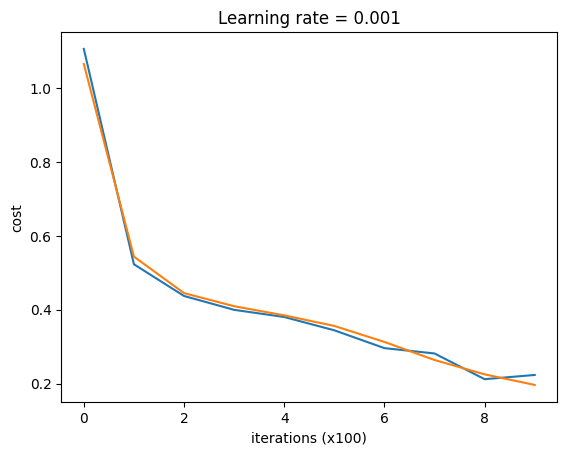

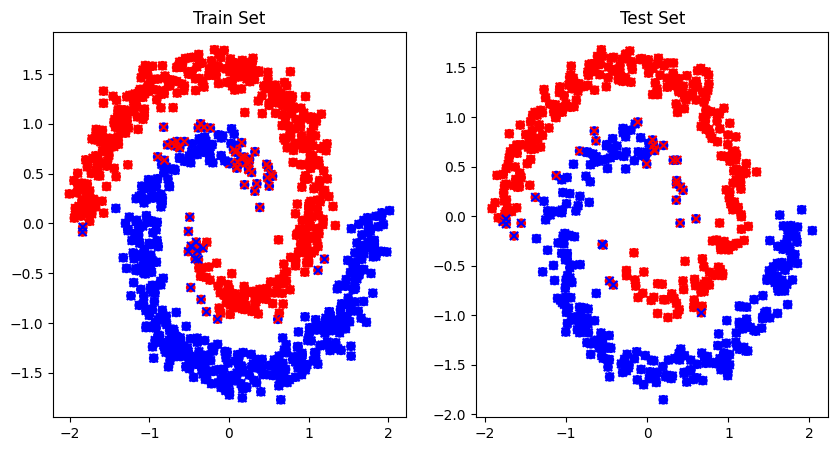

Learning rate : 0.005
Cost after epoch 1 batch_idx 0, Loss : 0.7420990467071533
Cost after epoch 101 batch_idx 0, Loss : 0.33945155143737793
Cost after epoch 201 batch_idx 0, Loss : 0.2149384319782257
Cost after epoch 301 batch_idx 0, Loss : 0.14348584413528442
Cost after epoch 401 batch_idx 0, Loss : 0.1547234058380127
Cost after epoch 501 batch_idx 0, Loss : 0.10425806045532227
Cost after epoch 601 batch_idx 0, Loss : 0.10273659974336624
Cost after epoch 701 batch_idx 0, Loss : 0.11809008568525314
Cost after epoch 801 batch_idx 0, Loss : 0.060907237231731415
Cost after epoch 901 batch_idx 0, Loss : 0.048477113246917725
*** Train set: Average loss: 0.0002, Accuracy: 995/1000 (100%)
*** Test set: Average loss: 0.0001, Accuracy: 589/600 (98%)


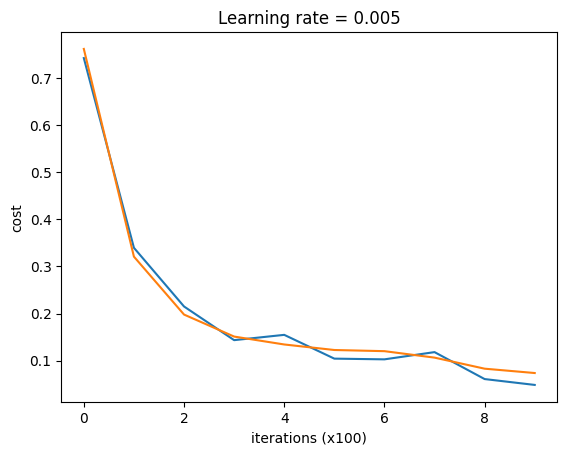

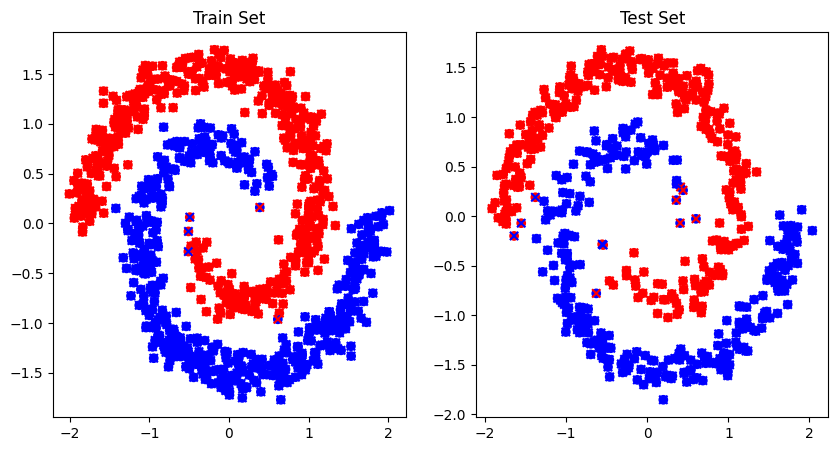

Learning rate : 0.01
Cost after epoch 1 batch_idx 0, Loss : 0.666164219379425
Cost after epoch 101 batch_idx 0, Loss : 0.20088255405426025
Cost after epoch 201 batch_idx 0, Loss : 0.1678374707698822
Cost after epoch 301 batch_idx 0, Loss : 0.1343623697757721
Cost after epoch 401 batch_idx 0, Loss : 0.16917841136455536
Cost after epoch 501 batch_idx 0, Loss : 0.07943977415561676
Cost after epoch 601 batch_idx 0, Loss : 0.055640898644924164
Cost after epoch 701 batch_idx 0, Loss : 0.06703589856624603
Cost after epoch 801 batch_idx 0, Loss : 0.05240273475646973
Cost after epoch 901 batch_idx 0, Loss : 0.050883613526821136
*** Train set: Average loss: 0.0002, Accuracy: 989/1000 (99%)
*** Test set: Average loss: 0.0001, Accuracy: 589/600 (98%)


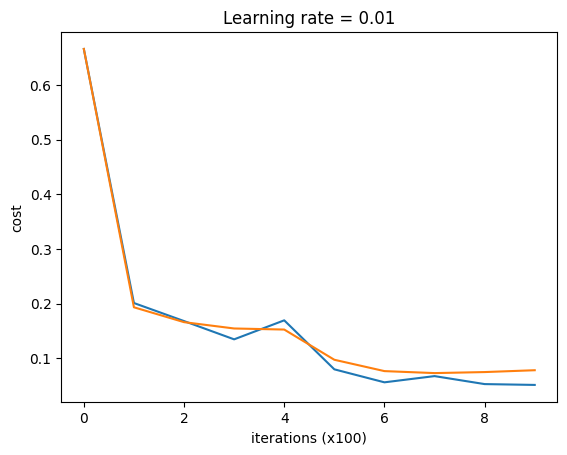

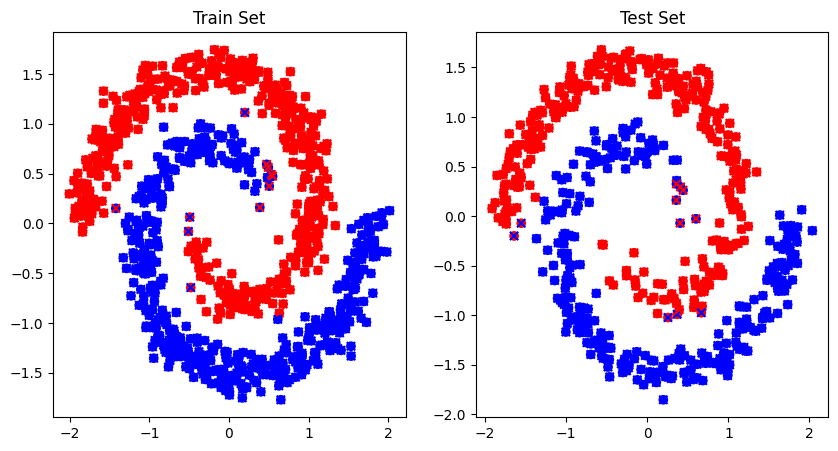

Learning rate : 0.05
Cost after epoch 1 batch_idx 0, Loss : 0.7411708235740662
Cost after epoch 101 batch_idx 0, Loss : 0.04063090682029724
Cost after epoch 201 batch_idx 0, Loss : 0.03595098480582237
Cost after epoch 301 batch_idx 0, Loss : 0.04550197720527649
Cost after epoch 401 batch_idx 0, Loss : 0.03603612259030342
Cost after epoch 501 batch_idx 0, Loss : 0.035481490194797516
Cost after epoch 601 batch_idx 0, Loss : 0.042586855590343475
Cost after epoch 701 batch_idx 0, Loss : 0.04326512664556503
Cost after epoch 801 batch_idx 0, Loss : 0.05477070063352585
Cost after epoch 901 batch_idx 0, Loss : 0.03970218822360039
*** Train set: Average loss: 0.0002, Accuracy: 996/1000 (100%)
*** Test set: Average loss: 0.0001, Accuracy: 591/600 (98%)


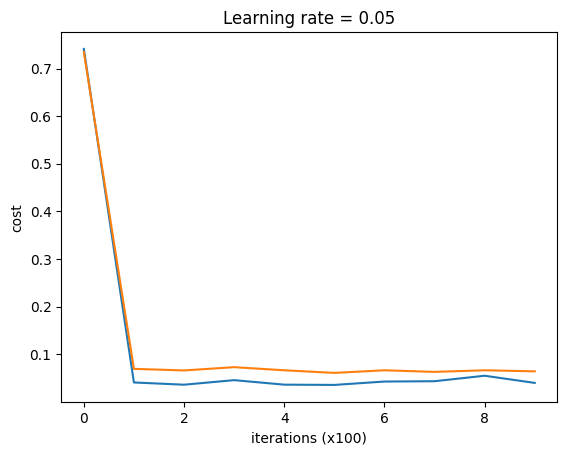

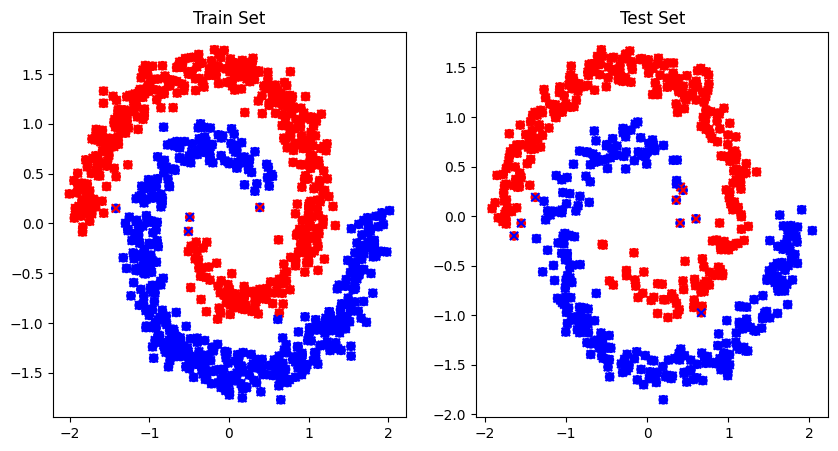

Learning rate : 0.1
Cost after epoch 1 batch_idx 0, Loss : 0.892392635345459
Cost after epoch 101 batch_idx 0, Loss : 0.03812208026647568
Cost after epoch 201 batch_idx 0, Loss : 0.03429880738258362
Cost after epoch 301 batch_idx 0, Loss : 0.04445252567529678
Cost after epoch 401 batch_idx 0, Loss : 0.03858884423971176
Cost after epoch 501 batch_idx 0, Loss : 0.041606880724430084
Cost after epoch 601 batch_idx 0, Loss : 0.051994744688272476
Cost after epoch 701 batch_idx 0, Loss : 0.042021218687295914
Cost after epoch 801 batch_idx 0, Loss : 0.04990020766854286
Cost after epoch 901 batch_idx 0, Loss : 0.03182654455304146
*** Train set: Average loss: 0.0002, Accuracy: 996/1000 (100%)
*** Test set: Average loss: 0.0001, Accuracy: 592/600 (99%)


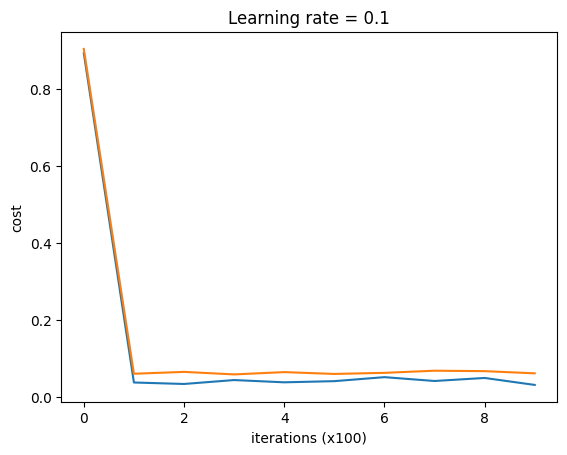

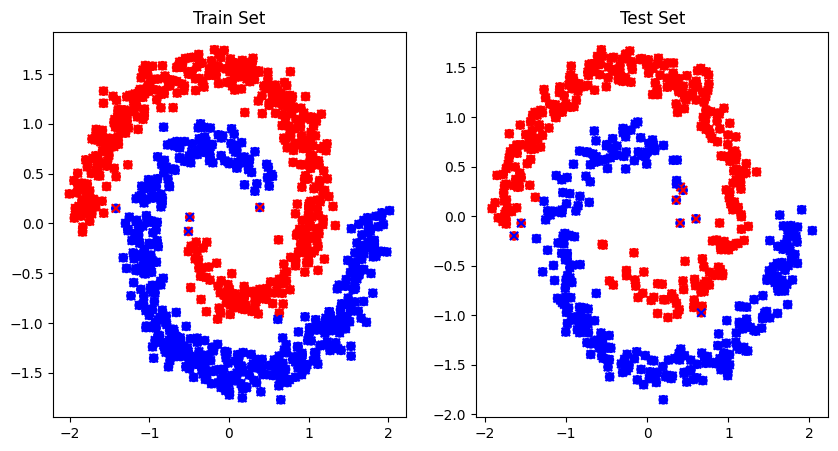

Learning rate : 0.3
Cost after epoch 1 batch_idx 0, Loss : 0.8366533517837524
Cost after epoch 101 batch_idx 0, Loss : 0.05917106941342354
Cost after epoch 201 batch_idx 0, Loss : 0.04220768064260483
Cost after epoch 301 batch_idx 0, Loss : 0.0492112897336483
Cost after epoch 401 batch_idx 0, Loss : 0.04860209673643112
Cost after epoch 501 batch_idx 0, Loss : 0.04505452513694763
Cost after epoch 601 batch_idx 0, Loss : 0.05120066553354263
Cost after epoch 701 batch_idx 0, Loss : 0.04518704116344452
Cost after epoch 801 batch_idx 0, Loss : 0.04334705322980881
Cost after epoch 901 batch_idx 0, Loss : 0.03699251264333725
*** Train set: Average loss: 0.0002, Accuracy: 993/1000 (99%)
*** Test set: Average loss: 0.0001, Accuracy: 593/600 (99%)


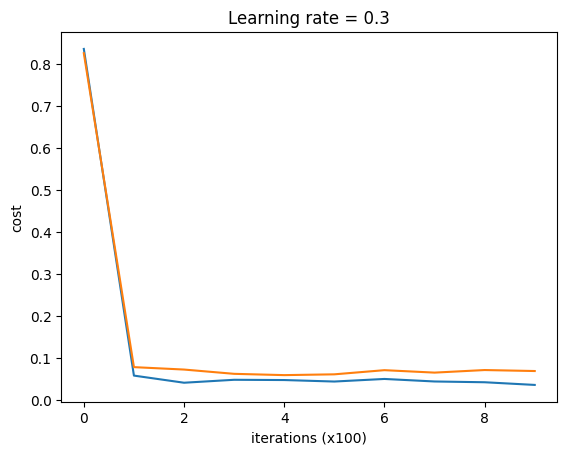

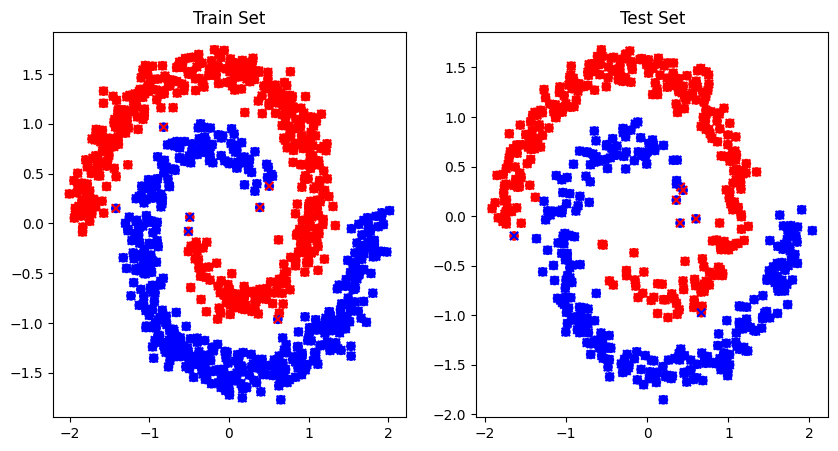

Learning rate : 0.5
Cost after epoch 1 batch_idx 0, Loss : 0.7549117803573608
Cost after epoch 101 batch_idx 0, Loss : 0.04304908215999603
Cost after epoch 201 batch_idx 0, Loss : 0.049319446086883545
Cost after epoch 301 batch_idx 0, Loss : 0.053969040513038635
Cost after epoch 401 batch_idx 0, Loss : 0.05522582307457924
Cost after epoch 501 batch_idx 0, Loss : 0.054162606596946716
Cost after epoch 601 batch_idx 0, Loss : 0.04328206926584244
Cost after epoch 701 batch_idx 0, Loss : 0.14255253970623016
Cost after epoch 801 batch_idx 0, Loss : 0.18460097908973694
Cost after epoch 901 batch_idx 0, Loss : 0.16941186785697937
*** Train set: Average loss: 0.0007, Accuracy: 930/1000 (93%)
*** Test set: Average loss: 0.0003, Accuracy: 552/600 (92%)


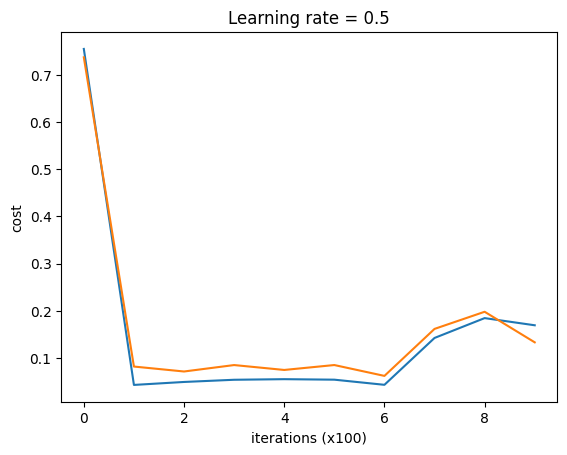

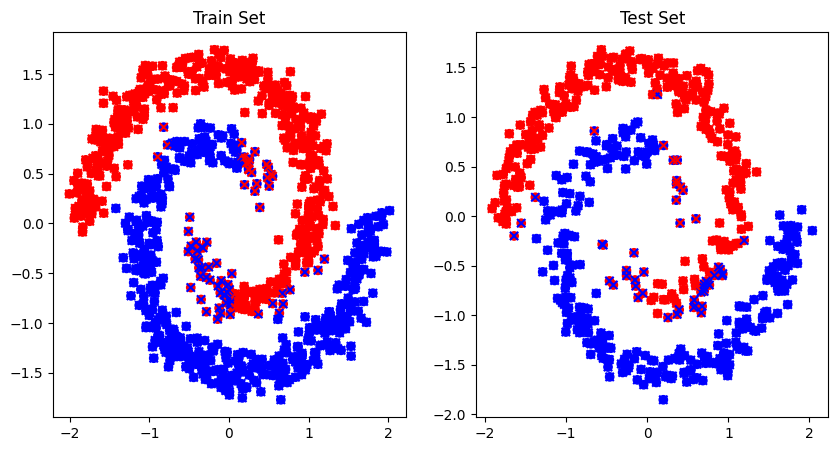

In [ ]:
# learning rate의 변화에 따른 정확도 확인 num_iterations : 1000, lambd : 0.001
rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]

train_list2 = []
test_list2 = []

print("[Learning rate의 변화에 따른 정확도 확인] - (num_iterations : 1000, lambd : 0.001)")
for i in rate:
  print("Learning rate :", i)
  train_acc, test_acc = model(learning_rate=i, num_iterations=1000, lambd=0.001)
  train_acc_value = train_acc.item()  # 실제 값을 추출
  test_acc_value = test_acc.item()  # 실제 값을 추출
  train_list2.append(train_acc_value)
  test_list2.append(test_acc_value)

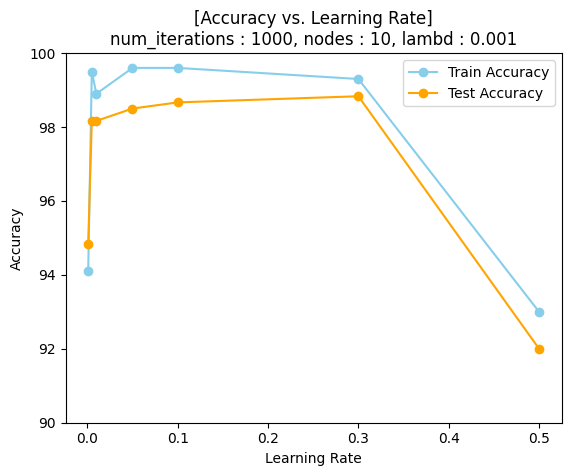

In [ ]:
# Train, test 정확도 확인 plot - num_iterations : 1000, lambd : 0.001
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]

fig2, ax2 = plt.subplots()
ax2.plot(learning_rates, train_list2, color='skyblue', marker='o', label='Train Accuracy')
ax2.plot(learning_rates, test_list2, color='orange', marker='o', label='Test Accuracy')
ax2.set_xlabel('Learning Rate')
ax2.set_ylabel('Accuracy')
ax2.set_title('[Accuracy vs. Learning Rate]\nnum_iterations : 1000, nodes : 10, lambd : 0.001')
ax2.set_ylim(90, 100)
ax2.legend()

# 변수에 그림 저장
saved_plot2 = fig2

# 그림 출력
plt.show()

# **3. learning rate의 변화에 따른 정확도 확인 num_iterations : 2000, node : 10, lambd : 0.001**

   learning rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]

[Learning rate의 변화에 따른 정확도 확인] - (num_iterations : 2000, lambd : 0.001)
Learning rate : 0.001
Cost after epoch 1 batch_idx 0, Loss : 0.6821985244750977
Cost after epoch 101 batch_idx 0, Loss : 0.46606671810150146
Cost after epoch 201 batch_idx 0, Loss : 0.4286789894104004
Cost after epoch 301 batch_idx 0, Loss : 0.3723912835121155
Cost after epoch 401 batch_idx 0, Loss : 0.3629208207130432
Cost after epoch 501 batch_idx 0, Loss : 0.31921976804733276
Cost after epoch 601 batch_idx 0, Loss : 0.20876121520996094
Cost after epoch 701 batch_idx 0, Loss : 0.18213550746440887
Cost after epoch 801 batch_idx 0, Loss : 0.13513126969337463
Cost after epoch 901 batch_idx 0, Loss : 0.09619762003421783
Cost after epoch 1001 batch_idx 0, Loss : 0.08742942661046982
Cost after epoch 1101 batch_idx 0, Loss : 0.07189188152551651
Cost after epoch 1201 batch_idx 0, Loss : 0.058265767991542816
Cost after epoch 1301 batch_idx 0, Loss : 0.05687280744314194
Cost after epoch 1401 batch_idx 0, Loss : 0.071868911

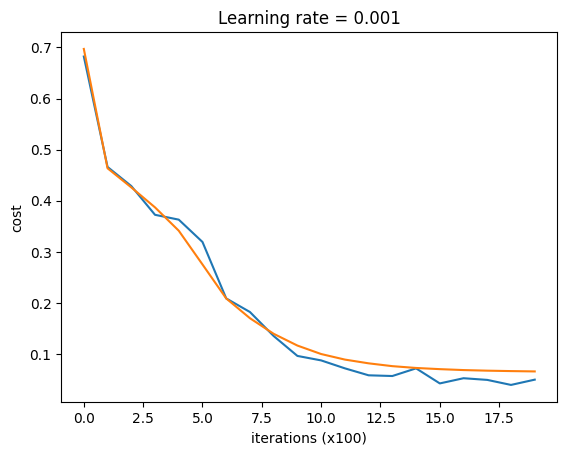

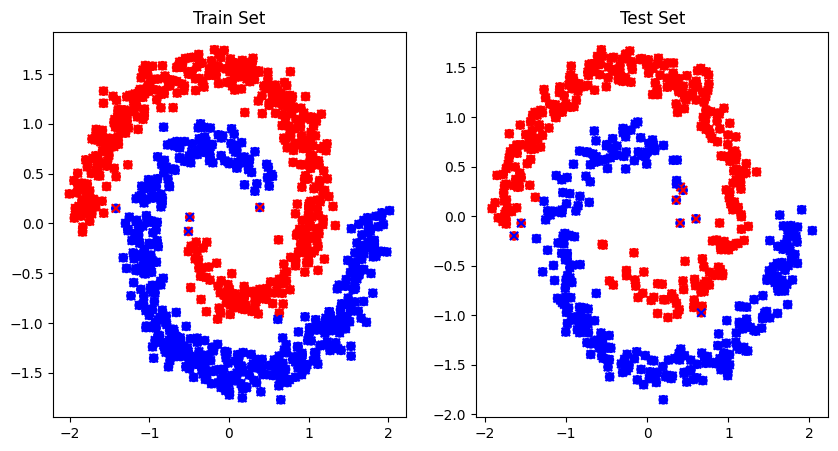

Learning rate : 0.005
Cost after epoch 1 batch_idx 0, Loss : 0.7971428632736206
Cost after epoch 101 batch_idx 0, Loss : 0.2704588770866394
Cost after epoch 201 batch_idx 0, Loss : 0.1315719187259674
Cost after epoch 301 batch_idx 0, Loss : 0.08551914989948273
Cost after epoch 401 batch_idx 0, Loss : 0.06906572729349136
Cost after epoch 501 batch_idx 0, Loss : 0.06350906938314438
Cost after epoch 601 batch_idx 0, Loss : 0.05597551912069321
Cost after epoch 701 batch_idx 0, Loss : 0.03681319206953049
Cost after epoch 801 batch_idx 0, Loss : 0.05190960317850113
Cost after epoch 901 batch_idx 0, Loss : 0.030391531065106392
Cost after epoch 1001 batch_idx 0, Loss : 0.04947764798998833
Cost after epoch 1101 batch_idx 0, Loss : 0.05064011365175247
Cost after epoch 1201 batch_idx 0, Loss : 0.051708586513996124
Cost after epoch 1301 batch_idx 0, Loss : 0.04628361016511917
Cost after epoch 1401 batch_idx 0, Loss : 0.04299156740307808
Cost after epoch 1501 batch_idx 0, Loss : 0.04987684637308121

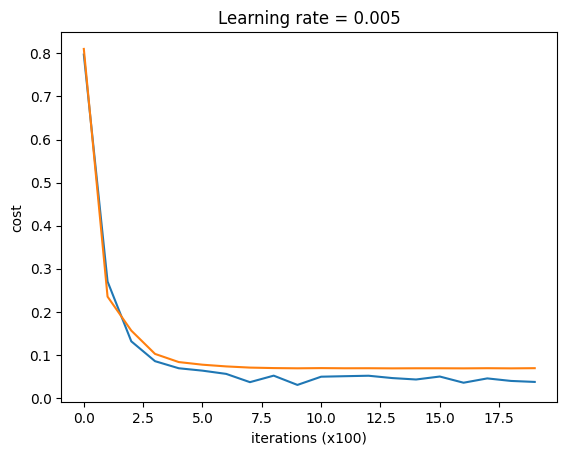

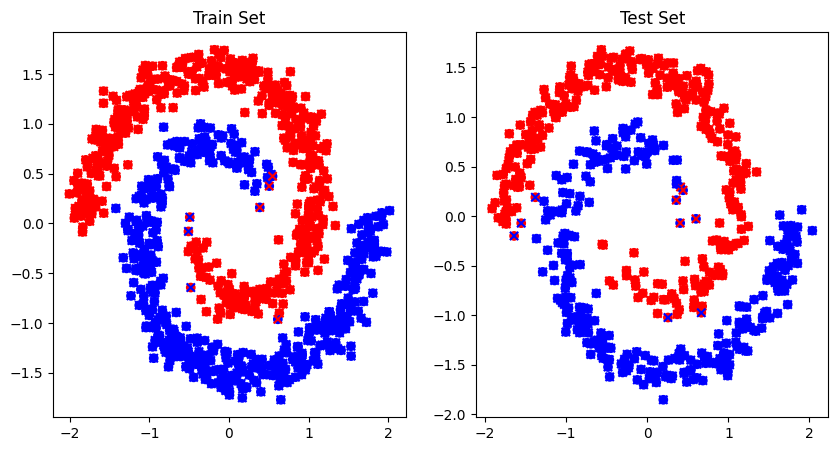

Learning rate : 0.01
Cost after epoch 1 batch_idx 0, Loss : 0.6526979207992554
Cost after epoch 101 batch_idx 0, Loss : 0.1704365611076355
Cost after epoch 201 batch_idx 0, Loss : 0.10751838237047195
Cost after epoch 301 batch_idx 0, Loss : 0.060188405215740204
Cost after epoch 401 batch_idx 0, Loss : 0.0629434883594513
Cost after epoch 501 batch_idx 0, Loss : 0.061923444271087646
Cost after epoch 601 batch_idx 0, Loss : 0.06830918043851852
Cost after epoch 701 batch_idx 0, Loss : 0.05433015525341034
Cost after epoch 801 batch_idx 0, Loss : 0.059089094400405884
Cost after epoch 901 batch_idx 0, Loss : 0.05630140379071236
Cost after epoch 1001 batch_idx 0, Loss : 0.045048169791698456
Cost after epoch 1101 batch_idx 0, Loss : 0.05108786001801491
Cost after epoch 1201 batch_idx 0, Loss : 0.052244849503040314
Cost after epoch 1301 batch_idx 0, Loss : 0.05247402936220169
Cost after epoch 1401 batch_idx 0, Loss : 0.04017077758908272
Cost after epoch 1501 batch_idx 0, Loss : 0.050635483115911

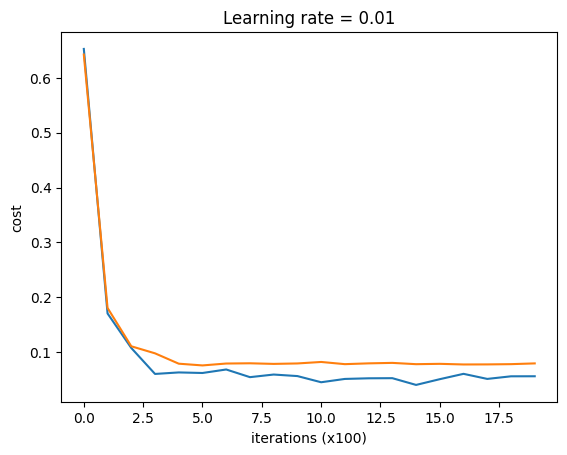

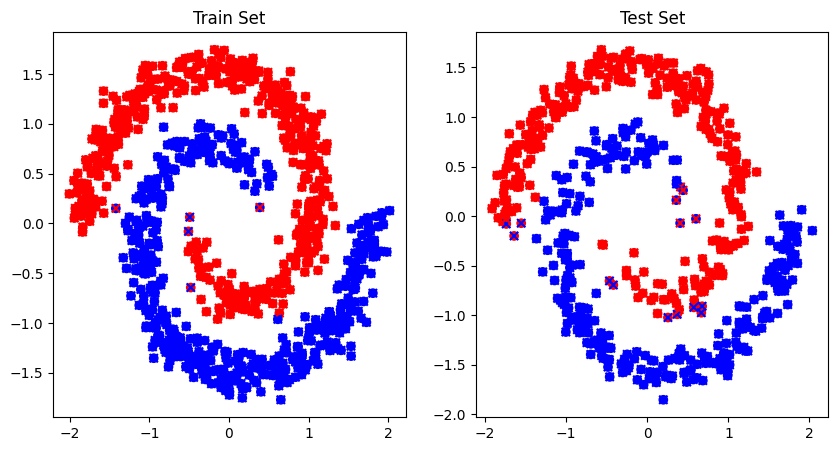

Learning rate : 0.05
Cost after epoch 1 batch_idx 0, Loss : 0.6220026016235352
Cost after epoch 101 batch_idx 0, Loss : 0.045359861105680466
Cost after epoch 201 batch_idx 0, Loss : 0.04855144023895264
Cost after epoch 301 batch_idx 0, Loss : 0.044320642948150635
Cost after epoch 401 batch_idx 0, Loss : 0.047331903129816055
Cost after epoch 501 batch_idx 0, Loss : 0.04191773384809494
Cost after epoch 601 batch_idx 0, Loss : 0.03599289804697037
Cost after epoch 701 batch_idx 0, Loss : 0.0401529036462307
Cost after epoch 801 batch_idx 0, Loss : 0.04149622470140457
Cost after epoch 901 batch_idx 0, Loss : 0.041867487132549286
Cost after epoch 1001 batch_idx 0, Loss : 0.039618462324142456
Cost after epoch 1101 batch_idx 0, Loss : 0.04264700412750244
Cost after epoch 1201 batch_idx 0, Loss : 0.04786089062690735
Cost after epoch 1301 batch_idx 0, Loss : 0.048526082187891006
Cost after epoch 1401 batch_idx 0, Loss : 0.037998318672180176
Cost after epoch 1501 batch_idx 0, Loss : 0.034822732210

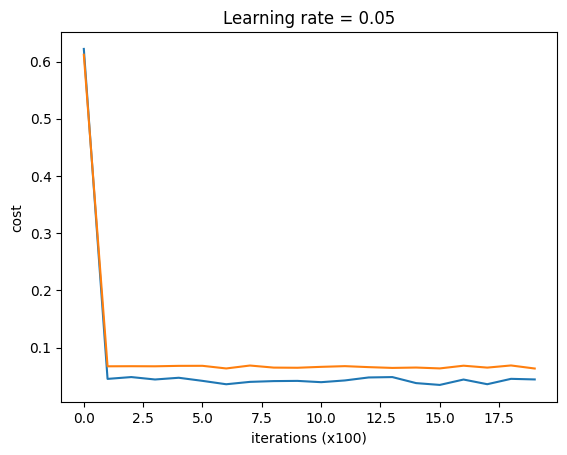

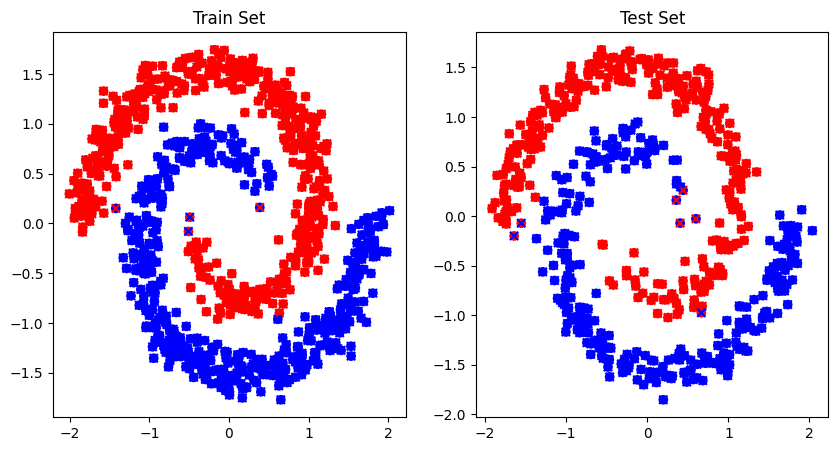

Learning rate : 0.1
Cost after epoch 1 batch_idx 0, Loss : 0.5925235748291016
Cost after epoch 101 batch_idx 0, Loss : 0.03787170723080635
Cost after epoch 201 batch_idx 0, Loss : 0.040516842156648636
Cost after epoch 301 batch_idx 0, Loss : 0.04968195781111717
Cost after epoch 401 batch_idx 0, Loss : 0.05270916968584061
Cost after epoch 501 batch_idx 0, Loss : 0.0431094728410244
Cost after epoch 601 batch_idx 0, Loss : 0.041273169219493866
Cost after epoch 701 batch_idx 0, Loss : 0.04157914221286774
Cost after epoch 801 batch_idx 0, Loss : 0.052418917417526245
Cost after epoch 901 batch_idx 0, Loss : 0.04312992841005325
Cost after epoch 1001 batch_idx 0, Loss : 0.04712213575839996
Cost after epoch 1101 batch_idx 0, Loss : 0.03677186369895935
Cost after epoch 1201 batch_idx 0, Loss : 0.048638638108968735
Cost after epoch 1301 batch_idx 0, Loss : 0.04765070974826813
Cost after epoch 1401 batch_idx 0, Loss : 0.049813900142908096
Cost after epoch 1501 batch_idx 0, Loss : 0.041091948747634

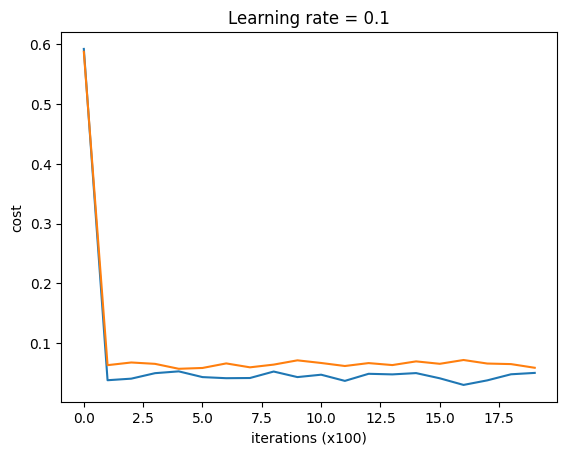

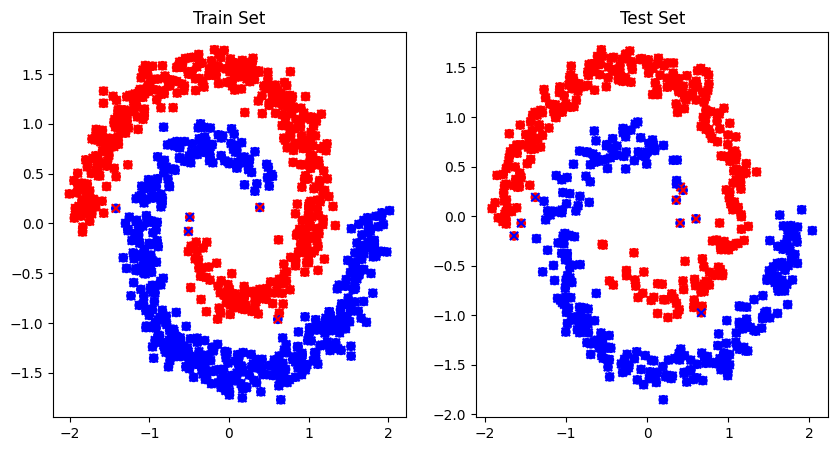

Learning rate : 0.3
Cost after epoch 1 batch_idx 0, Loss : 0.7015855312347412
Cost after epoch 101 batch_idx 0, Loss : 0.0636272206902504
Cost after epoch 201 batch_idx 0, Loss : 0.05724585801362991
Cost after epoch 301 batch_idx 0, Loss : 0.03934108838438988
Cost after epoch 401 batch_idx 0, Loss : 0.04211031645536423
Cost after epoch 501 batch_idx 0, Loss : 0.059247784316539764
Cost after epoch 601 batch_idx 0, Loss : 0.04677603021264076
Cost after epoch 701 batch_idx 0, Loss : 0.05277175456285477
Cost after epoch 801 batch_idx 0, Loss : 0.05883412063121796
Cost after epoch 901 batch_idx 0, Loss : 0.05351945012807846
Cost after epoch 1001 batch_idx 0, Loss : 0.03828062117099762
Cost after epoch 1101 batch_idx 0, Loss : 0.039036527276039124
Cost after epoch 1201 batch_idx 0, Loss : 0.0568944588303566
Cost after epoch 1301 batch_idx 0, Loss : 0.04406392574310303
Cost after epoch 1401 batch_idx 0, Loss : 0.049287084490060806
Cost after epoch 1501 batch_idx 0, Loss : 0.044934891164302826

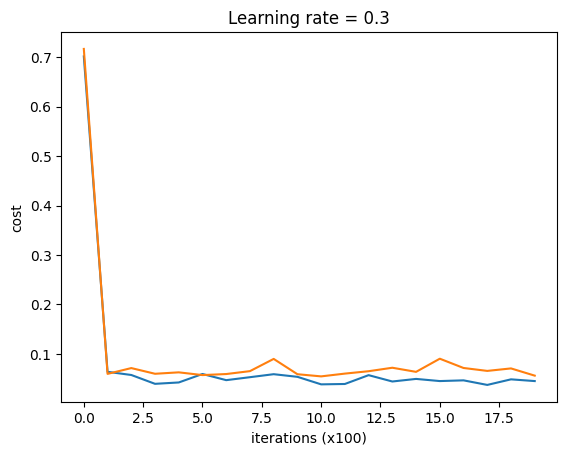

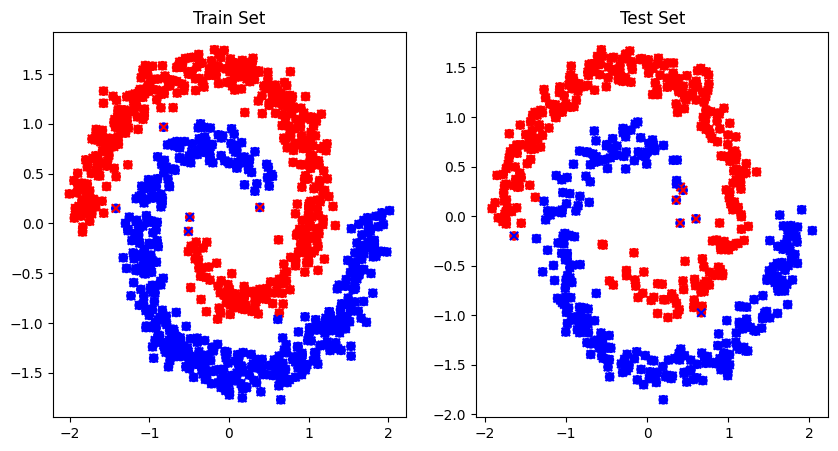

Learning rate : 0.5
Cost after epoch 1 batch_idx 0, Loss : 0.8122682571411133
Cost after epoch 101 batch_idx 0, Loss : 0.06471338868141174
Cost after epoch 201 batch_idx 0, Loss : 0.04061473160982132
Cost after epoch 301 batch_idx 0, Loss : 0.04056810587644577
Cost after epoch 401 batch_idx 0, Loss : 0.040034905076026917
Cost after epoch 501 batch_idx 0, Loss : 0.057693298906087875
Cost after epoch 601 batch_idx 0, Loss : 0.06888197362422943
Cost after epoch 701 batch_idx 0, Loss : 0.03699671849608421
Cost after epoch 801 batch_idx 0, Loss : 0.06315796822309494
Cost after epoch 901 batch_idx 0, Loss : 0.03845730796456337
Cost after epoch 1001 batch_idx 0, Loss : 0.04013952612876892
Cost after epoch 1101 batch_idx 0, Loss : 0.10485579073429108
Cost after epoch 1201 batch_idx 0, Loss : 0.05935049429535866
Cost after epoch 1301 batch_idx 0, Loss : 0.03970782831311226
Cost after epoch 1401 batch_idx 0, Loss : 0.04960015043616295
Cost after epoch 1501 batch_idx 0, Loss : 0.04472796618938446

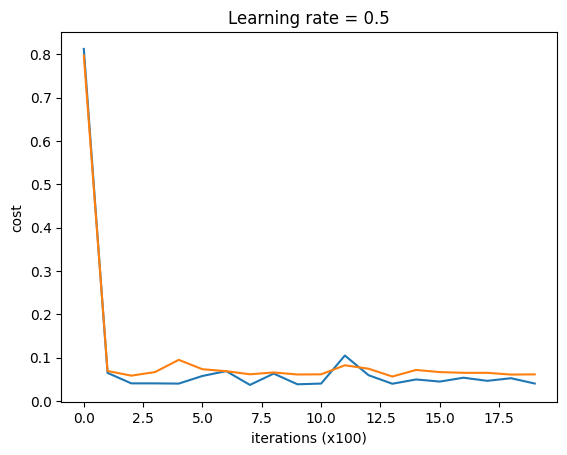

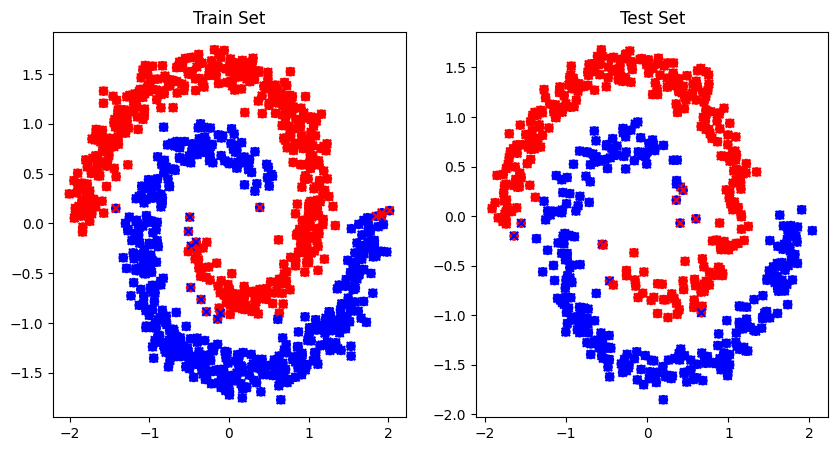

In [ ]:
# learning rate의 변화에 따른 정확도 확인 num_iterations : 2000, lambd : 0.001
rate = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]

train_list3 = []
test_list3 = []

print("[Learning rate의 변화에 따른 정확도 확인] - (num_iterations : 2000, lambd : 0.001)")
for i in rate:
  print("Learning rate :", i)
  train_acc, test_acc = model(learning_rate=i, num_iterations=2000, lambd=0.001)
  train_acc_value = train_acc.item()  # 실제 값을 추출
  test_acc_value = test_acc.item()  # 실제 값을 추출
  train_list3.append(train_acc_value)
  test_list3.append(test_acc_value)

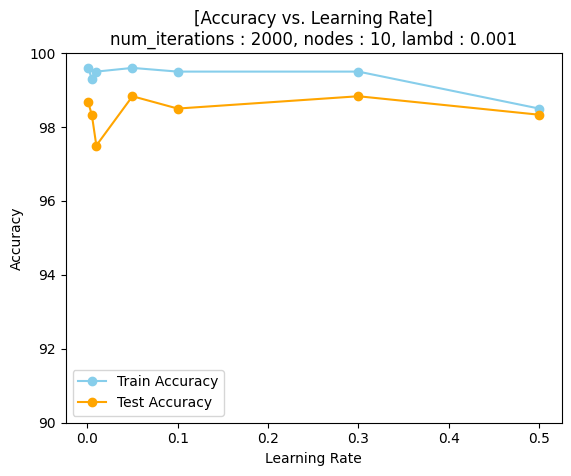

In [ ]:
# Train, test 정확도 확인 plot - num_iterations : 2000, lambd : 0.001
learning_rates = [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]

fig3, ax3 = plt.subplots()
ax3.plot(learning_rates, train_list3, color='skyblue', marker='o', label='Train Accuracy')
ax3.plot(learning_rates, test_list3, color='orange', marker='o', label='Test Accuracy')
ax3.set_xlabel('Learning Rate')
ax3.set_ylabel('Accuracy')
ax3.set_title('[Accuracy vs. Learning Rate]\nnum_iterations : 2000, nodes : 10, lambd : 0.001')
ax3.set_ylim(90, 100)
ax3.legend()

# 변수에 그림 저장
saved_plot3 = fig3

# 그림 출력
plt.show()

# **4. Hidden Node 수의 변화가 모델의 정확도에 어떤 영향을 미치는지 확인하기 위해 새로운 model 함수 정의**

model2( learning_rate = 0.3, num_iterations = 30000, print_cost = True, **node = 10**, lambd = 0., keep_prob = 1.)

In [ ]:
def model2( learning_rate = 0.3, num_iterations = 10000, node = 10, print_cost = True, lambd = 0., keep_prob = 1.):

    costs = []                            # to keep track of the cost
    test_costs = []
    train_acc = 0
    test_acc = 0

    x_dim = 2
    layers_dims = [2, node, 1]

    nnmodel = NNModel(layers_dims, 1.0-keep_prob)
    optimizer = optim.Adam(nnmodel.parameters(), lr=learning_rate, weight_decay=lambd )

    nnmodel = nnmodel.to(device)

    def train(epoch):
        nnmodel.train()
        for batch_idx, (train_x, train_y) in enumerate(train_loader):
            (test_x, test_y) = next(iter(test_loader))

            train_x = train_x.to(device)
            train_y = train_y.to(device)
            test_x = test_x.to(device)
            test_y = test_y.to(device)

            output = nnmodel(train_x)
            test_output = nnmodel(test_x)

            optimizer.zero_grad()
            loss = F.binary_cross_entropy(output, train_y)
            with torch.no_grad():
                test_loss = F.binary_cross_entropy(test_output, test_y)

            loss.backward()
            optimizer.step()
            if epoch%100==1 and batch_idx==0:
                print("Cost after epoch {} batch_idx {}, Loss : {}".format(epoch, batch_idx, loss))
                costs.append(loss.item())
                test_costs.append(test_loss.item())

    def test():
        test_loss=0
        correct=0
        nnmodel.eval()

        for data,target in train_loader:
            data = data.to(device)
            target = target.to(device)

            output = nnmodel(data)
            test_loss += F.binary_cross_entropy(output, target)
#            test_loss += F.binary_cross_entropy(output, target.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor))
            pred = (output>0.5)

            temp = pred.eq(target.view_as(pred))
            correct += temp.sum()
        test_loss /= len(train_loader.dataset)
        train_acc = 100. * correct / len(train_loader.dataset)
        print('*** Train set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                test_loss, correct, len(train_loader.dataset),
                train_acc))

        test_loss=0
        correct=0
        for data,target in test_loader:
            data = data.to(device)
            target = target.to(device)

            output = nnmodel(data)
            test_loss += F.binary_cross_entropy(output, target )
#            test_loss += F.binary_cross_entropy(output, target.type(torch.cuda.FloatTensor if torch.cuda.is_available() else torch.FloatTensor))
            pred = (output>0.5)
            temp = pred.eq(target.view_as(pred))
            correct += temp.sum()
        test_loss /= len(test_loader.dataset)
        test_acc = 100. * correct / len(test_loader.dataset)
        print('*** Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
                test_loss, correct, len(test_loader.dataset),
                test_acc))
        return train_acc, test_acc

    for epoch in range(1,num_iterations):
       train(epoch)
    train_acc, test_acc = test()

    # plot the cost
    plt.plot(costs)
    plt.plot(test_costs)
    plt.ylabel('cost')
    plt.xlabel('iterations (x100)')
    plt.title("Learning rate = " + str(learning_rate))
    plt.show()

    # Plot decision boundary
    plot_decision_boundary(nnmodel, train_loader, test_loader)

    return train_acc, test_acc

[Hidden layer의 node 수에 따른 정확도 확인]
[ node 개수 : 1 ]
Cost after epoch 1 batch_idx 0, Loss : 0.7500954270362854
Cost after epoch 101 batch_idx 0, Loss : 0.4585072100162506
Cost after epoch 201 batch_idx 0, Loss : 0.5072017312049866
Cost after epoch 301 batch_idx 0, Loss : 0.47690296173095703
Cost after epoch 401 batch_idx 0, Loss : 0.5068756341934204
Cost after epoch 501 batch_idx 0, Loss : 0.5111795663833618
Cost after epoch 601 batch_idx 0, Loss : 0.5001699924468994
Cost after epoch 701 batch_idx 0, Loss : 0.49640196561813354
Cost after epoch 801 batch_idx 0, Loss : 0.48868370056152344
Cost after epoch 901 batch_idx 0, Loss : 0.4902079701423645
*** Train set: Average loss: 0.0020, Accuracy: 747/1000 (75%)
*** Test set: Average loss: 0.0009, Accuracy: 431/600 (72%)


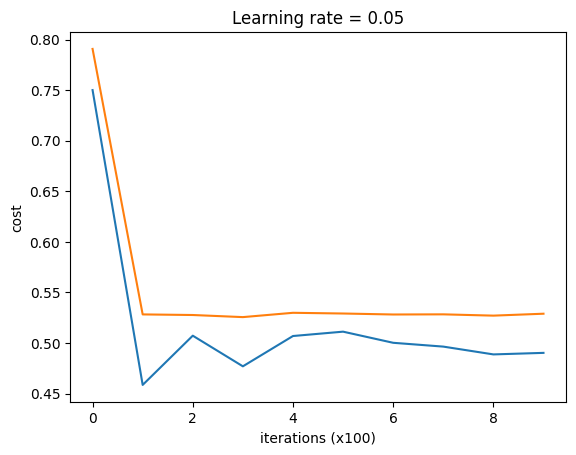

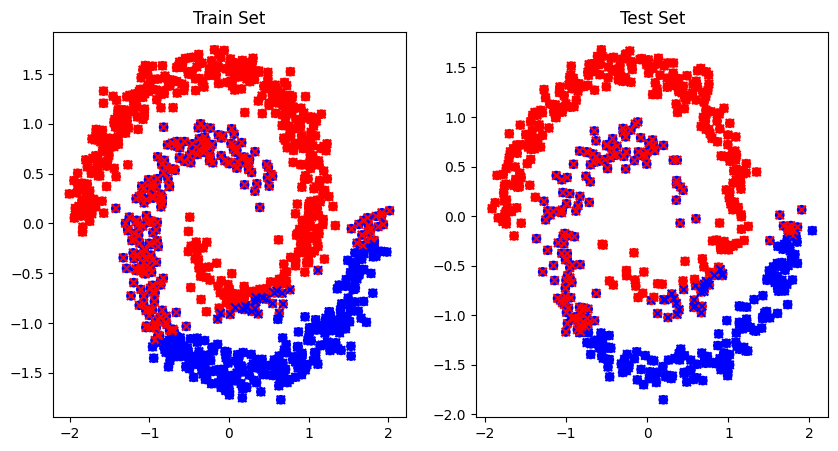

[ node 개수 : 5 ]
Cost after epoch 1 batch_idx 0, Loss : 0.7033590078353882
Cost after epoch 101 batch_idx 0, Loss : 0.12986505031585693
Cost after epoch 201 batch_idx 0, Loss : 0.10388429462909698
Cost after epoch 301 batch_idx 0, Loss : 0.13797849416732788
Cost after epoch 401 batch_idx 0, Loss : 0.12010927498340607
Cost after epoch 501 batch_idx 0, Loss : 0.14229221642017365
Cost after epoch 601 batch_idx 0, Loss : 0.1074746772646904
Cost after epoch 701 batch_idx 0, Loss : 0.13477686047554016
Cost after epoch 801 batch_idx 0, Loss : 0.12292256951332092
Cost after epoch 901 batch_idx 0, Loss : 0.13342313468456268
*** Train set: Average loss: 0.0005, Accuracy: 958/1000 (96%)
*** Test set: Average loss: 0.0002, Accuracy: 567/600 (94%)


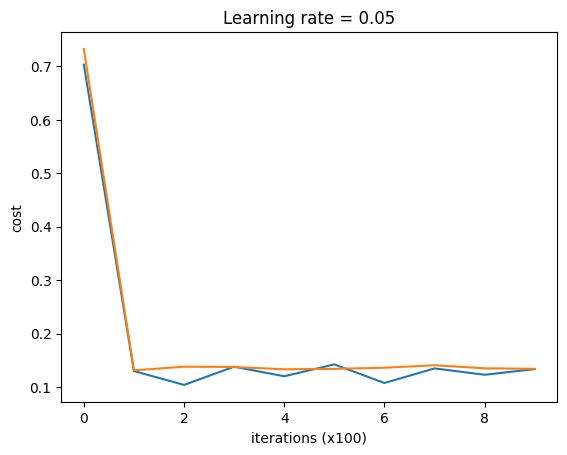

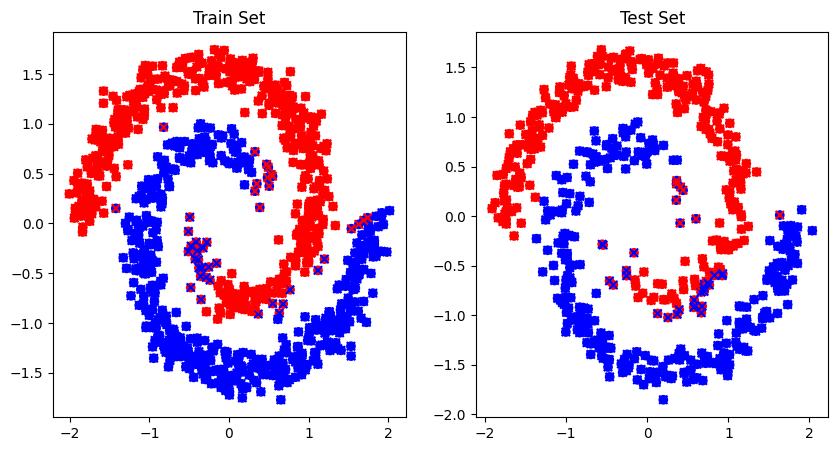

[ node 개수 : 10 ]
Cost after epoch 1 batch_idx 0, Loss : 0.7896639108657837
Cost after epoch 101 batch_idx 0, Loss : 0.0460563525557518
Cost after epoch 201 batch_idx 0, Loss : 0.04783329367637634
Cost after epoch 301 batch_idx 0, Loss : 0.03762437775731087
Cost after epoch 401 batch_idx 0, Loss : 0.04845908656716347
Cost after epoch 501 batch_idx 0, Loss : 0.0499555841088295
Cost after epoch 601 batch_idx 0, Loss : 0.04941226541996002
Cost after epoch 701 batch_idx 0, Loss : 0.040918976068496704
Cost after epoch 801 batch_idx 0, Loss : 0.04260232299566269
Cost after epoch 901 batch_idx 0, Loss : 0.03554579243063927
*** Train set: Average loss: 0.0002, Accuracy: 995/1000 (100%)
*** Test set: Average loss: 0.0001, Accuracy: 591/600 (98%)


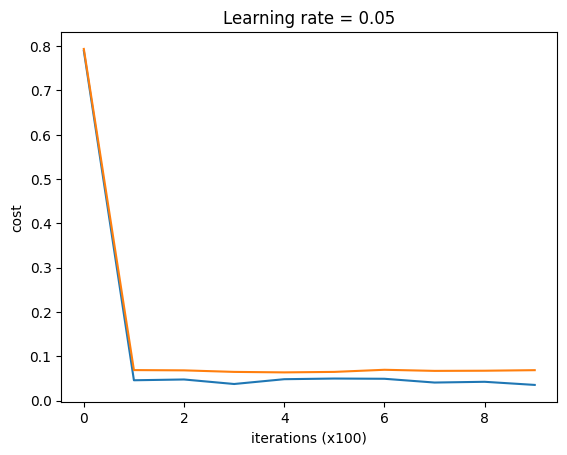

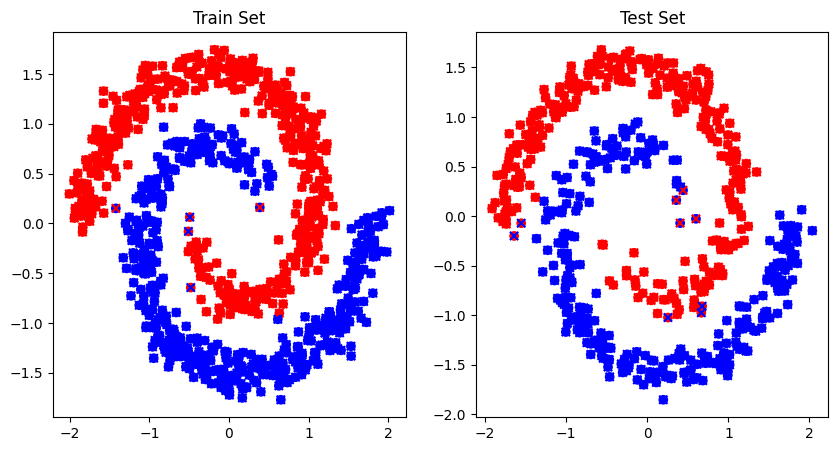

[ node 개수 : 15 ]
Cost after epoch 1 batch_idx 0, Loss : 0.8019661903381348
Cost after epoch 101 batch_idx 0, Loss : 0.04619671031832695
Cost after epoch 201 batch_idx 0, Loss : 0.053797647356987
Cost after epoch 301 batch_idx 0, Loss : 0.05260280519723892
Cost after epoch 401 batch_idx 0, Loss : 0.03675011545419693
Cost after epoch 501 batch_idx 0, Loss : 0.03571793809533119
Cost after epoch 601 batch_idx 0, Loss : 0.04560747370123863
Cost after epoch 701 batch_idx 0, Loss : 0.04050959646701813
Cost after epoch 801 batch_idx 0, Loss : 0.03702089935541153
Cost after epoch 901 batch_idx 0, Loss : 0.037452518939971924
*** Train set: Average loss: 0.0002, Accuracy: 995/1000 (100%)
*** Test set: Average loss: 0.0001, Accuracy: 591/600 (98%)


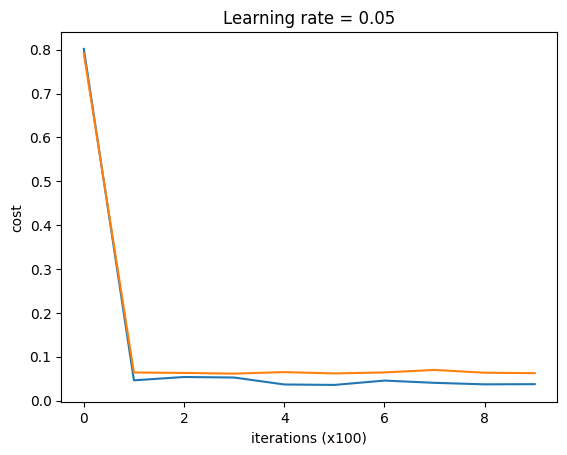

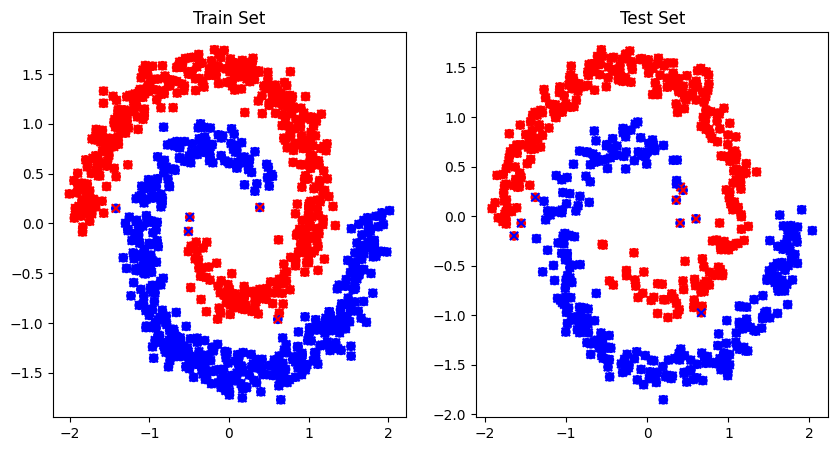

[ node 개수 : 20 ]
Cost after epoch 1 batch_idx 0, Loss : 0.6988451480865479
Cost after epoch 101 batch_idx 0, Loss : 0.04382556676864624
Cost after epoch 201 batch_idx 0, Loss : 0.05227978527545929
Cost after epoch 301 batch_idx 0, Loss : 0.053621575236320496
Cost after epoch 401 batch_idx 0, Loss : 0.04752707481384277
Cost after epoch 501 batch_idx 0, Loss : 0.03628221154212952
Cost after epoch 601 batch_idx 0, Loss : 0.038328349590301514
Cost after epoch 701 batch_idx 0, Loss : 0.050804078578948975
Cost after epoch 801 batch_idx 0, Loss : 0.045168377459049225
Cost after epoch 901 batch_idx 0, Loss : 0.05032816529273987
*** Train set: Average loss: 0.0002, Accuracy: 996/1000 (100%)
*** Test set: Average loss: 0.0001, Accuracy: 591/600 (98%)


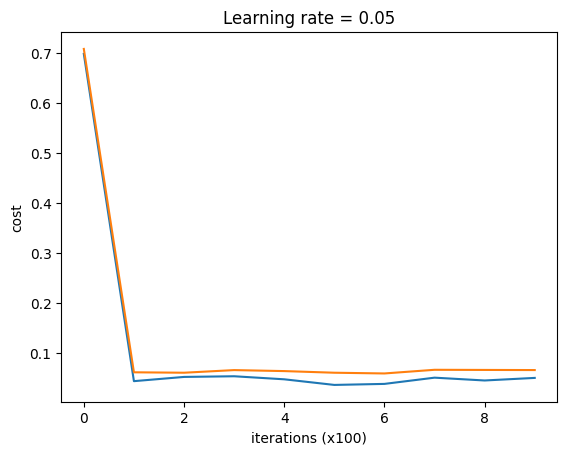

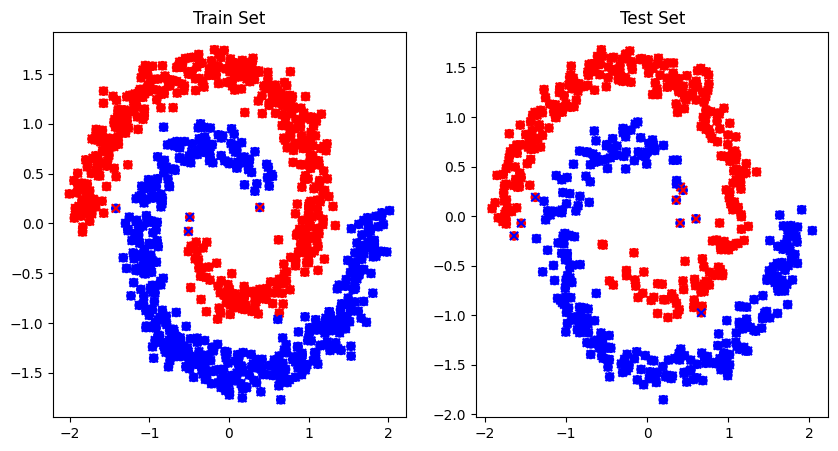

[ node 개수 : 25 ]
Cost after epoch 1 batch_idx 0, Loss : 0.5933096408843994
Cost after epoch 101 batch_idx 0, Loss : 0.04454987868666649
Cost after epoch 201 batch_idx 0, Loss : 0.04853202775120735
Cost after epoch 301 batch_idx 0, Loss : 0.04298041760921478
Cost after epoch 401 batch_idx 0, Loss : 0.04576266556978226
Cost after epoch 501 batch_idx 0, Loss : 0.04943370074033737
Cost after epoch 601 batch_idx 0, Loss : 0.04502737522125244
Cost after epoch 701 batch_idx 0, Loss : 0.04682305455207825
Cost after epoch 801 batch_idx 0, Loss : 0.050366632640361786
Cost after epoch 901 batch_idx 0, Loss : 0.03871427848935127
*** Train set: Average loss: 0.0002, Accuracy: 997/1000 (100%)
*** Test set: Average loss: 0.0001, Accuracy: 591/600 (98%)


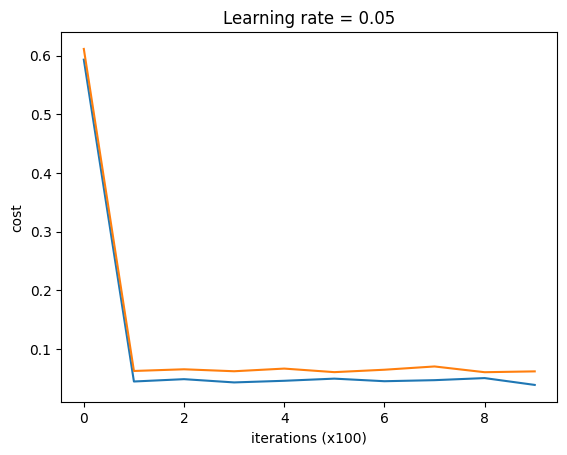

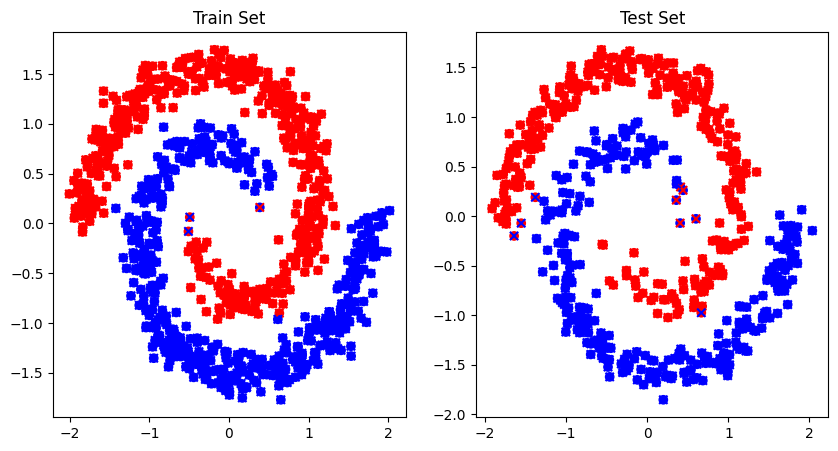

In [ ]:
# hidden layer의 node 수에 따른 정확도 확인
hidden_nodes = [1, 5, 10, 15, 20, 25]  # 다양한 은닉 노드 수 설정

train_list4 = []
test_list4 = []

print("[Hidden layer의 node 수에 따른 정확도 확인]")
for i in hidden_nodes:
  print("[ node 개수 :", i, "]")
  train_acc, test_acc = model2(learning_rate = 0.05, num_iterations = 1000, node = i, lambd = 0.001)
  train_acc_value = train_acc.item()  # 실제 값을 추출
  test_acc_value = test_acc.item()  # 실제 값을 추출
  train_list4.append(train_acc_value)
  test_list4.append(test_acc_value)

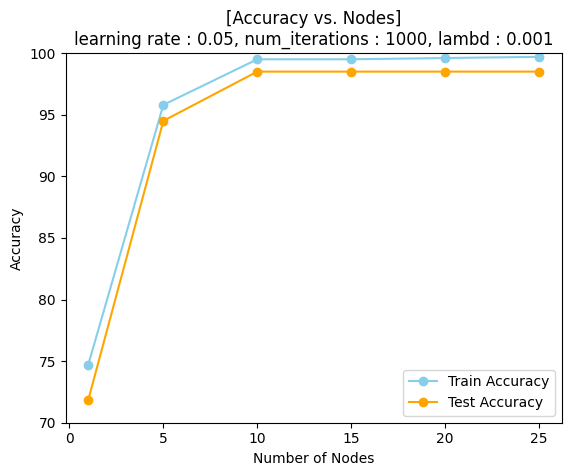

In [ ]:
# Node 수에 따른 정확도 확인 plot - num_iterations : 1000, lambd : 0.001
hidden_nodes = [1, 5, 10, 15, 20, 25]

fig4, ax4 = plt.subplots()
ax4.plot(hidden_nodes, train_list4, color='skyblue', marker='o', label='Train Accuracy')
ax4.plot(hidden_nodes, test_list4, color='orange', marker='o', label='Test Accuracy')
ax4.set_xlabel('Number of Nodes')
ax4.set_ylabel('Accuracy')
ax4.set_title('[Accuracy vs. Nodes]\nlearning rate : 0.05, num_iterations : 1000, lambd : 0.001')
ax4.set_ylim(70, 100)
ax4.legend()

# 변수에 그림 저장
saved_plot4 = fig4

# 그림 출력
plt.show()

#**최종 선택 모델**

In [ ]:
# 소수점 일의 자리까지 출력하는 함수
def format_float(number):
    return "{:.1f}".format(number)

# 모든 모델의 accuracy 확인
print("learning rate : [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]\n(node : 10, num_iterations : 1000, lambd : 0.)")
print("train acc :", [format_float(acc) for acc in train_list])
print("test acc :", [format_float(acc) for acc in test_list])
print("\nlearning rate : [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]\n(node : 10, num_iterations : 1000, lambd : 0.001)")
print("train acc :", [format_float(acc) for acc in train_list2])
print("test acc :", [format_float(acc) for acc in test_list2])
print("\nlearning rate : [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]\n(node : 10, num_iterations : 2000, lambd : 0.001)")
print("train acc :", [format_float(acc) for acc in train_list3])
print("test acc :", [format_float(acc) for acc in test_list3])
print("\nnode : [1, 5, 10, 15, 20, 25]\n(learning rate : 0.05, num_iterations : 1000, lambd : 0.001)")
print("train acc :", [format_float(acc) for acc in train_list4])
print("test acc :", [format_float(acc) for acc in test_list4])


learning rate : [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]
(node : 10, num_iterations : 1000, lambd : 0.)
train acc : ['74.7', '95.8', '99.5', '99.5', '99.6', '99.7']
test acc : ['83.5', '98.3', '98.5', '98.5', '99.0', '98.8', '99.0']

learning rate : [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]
(node : 10, num_iterations : 1000, lambd : 0.001)
train acc : ['94.1', '99.5', '98.9', '99.6', '99.6', '99.3', '93.0']
test acc : ['94.8', '98.2', '98.2', '98.5', '98.7', '98.8', '92.0']

learning rate : [0.001, 0.005, 0.01, 0.05, 0.1, 0.3, 0.5]
(node : 10, num_iterations : 2000, lambd : 0.001)
train acc : ['99.6', '99.3', '99.5', '99.6', '99.5', '99.5', '98.5']
test acc : ['98.7', '98.3', '97.5', '98.8', '98.5', '98.8', '98.3']

node : [1, 5, 10, 15, 20, 25]
(learning rate : 0.05, num_iterations : 1000, lambd : 0.001)
train acc : ['74.7', '95.8', '99.5', '99.5', '99.6', '99.7']
test acc : ['71.8', '94.5', '98.5', '98.5', '98.5', '98.5']


Cost after epoch 1 batch_idx 0, Loss : 0.8832063674926758
Cost after epoch 101 batch_idx 0, Loss : 0.24001438915729523
Cost after epoch 201 batch_idx 0, Loss : 0.12895050644874573
Cost after epoch 301 batch_idx 0, Loss : 0.1415722668170929
Cost after epoch 401 batch_idx 0, Loss : 0.12277203053236008
Cost after epoch 501 batch_idx 0, Loss : 0.14104242622852325
Cost after epoch 601 batch_idx 0, Loss : 0.12350192666053772
Cost after epoch 701 batch_idx 0, Loss : 0.13612157106399536
Cost after epoch 801 batch_idx 0, Loss : 0.11445118486881256
Cost after epoch 901 batch_idx 0, Loss : 0.0593990758061409
*** Train set: Average loss: 0.0002, Accuracy: 993/1000 (99%)
*** Test set: Average loss: 0.0001, Accuracy: 592/600 (99%)


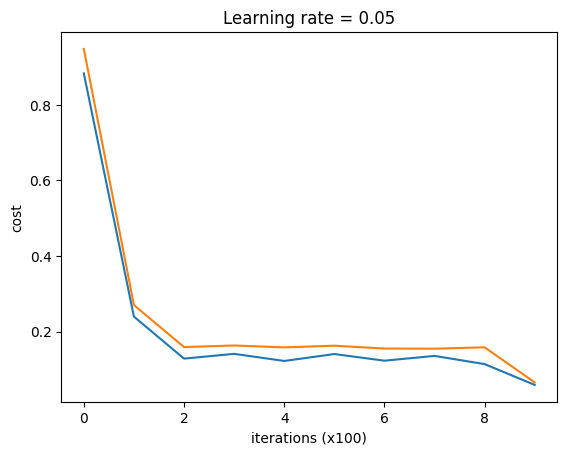

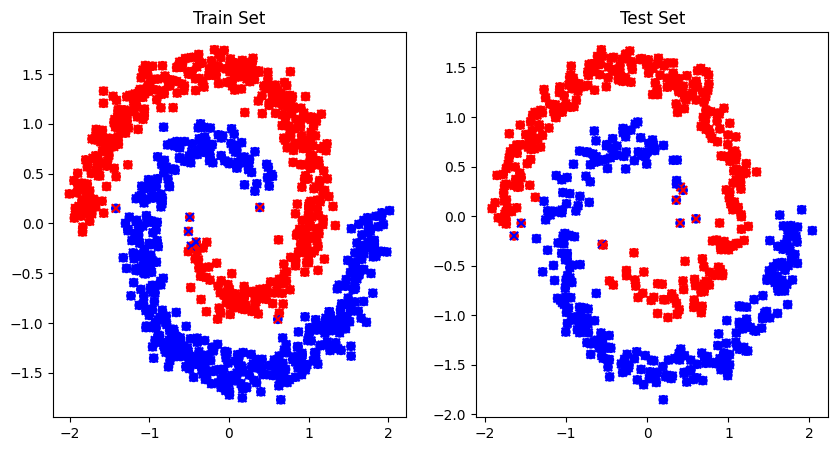

(tensor(99.3000, device='cuda:0'), tensor(98.6667, device='cuda:0'))

In [ ]:
# accuracy를 기반으로 최적 모델 선정.
model2(learning_rate = 0.05, node = 5, num_iterations = 1000,lambd = 0.001)